# Résumé du projet

<p align="center">
  <a href="https://colab.research.google.com/github/auduvignac/llm-finetuning/blob/main/notebooks/project/llm_finetuning.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Ouvrir dans Google Colab"/>
  </a>
</p>

Ce notebook présente une étude comparative du **fine-tuning de modèles Transformers** sur une tâche de classification de sentiments (reviews IMDB).

Nous avons structuré le travail en plusieurs étapes complémentaires : **exploration des données, préparation des entrées, entraînement, vérifications de cohérence, inférence qualitative, et comparaison quantitative des modèles**.

Plus précisément, nous nous sommes concentrés sur plusieurs étapes clés. Tout d’abord, nous avons mis en place un workflow clair permettant d’exécuter différents modèles en production. Nous avons ensuite travaillé sur DistilBERT et sur sa comparaison avec RoBERTa, en utilisant aussi bien les versions limitées à 256 tokens que celles étendues à 512 tokens. Ce travail a été mené après une étude exploratoire des données. Enfin, nous avons appliqué les meilleurs modèles entraînés à un jeu de données totalement nouveau afin d’évaluer la capacité de généralisation de notre fine-tuning.

## Modèles utilisés

### Les *Transformers*

Les modèles DistilBERT et RoBERTa appartiennent à la famille des *Transformers*, une architecture introduite en 2017 par Vaswani et al. dans *Attention is All You Need*.
L’idée principale repose sur le mécanisme d’**attention**, qui permet à un modèle de pondérer l’importance relative de chaque mot d’une séquence par rapport aux autres. Contrairement aux réseaux récurrents (RNN, LSTM) qui traitaient les séquences de manière séquentielle, les *Transformers* exploitent le traitement parallèle et une meilleure gestion des dépendances à long terme.
Ces caractéristiques ont rendu les Transformers incontournables dans le domaine du **traitement automatique du langage naturel (NLP)**.

Le figure ci-dessous illsutre l'évolution des architectures des RNN aux *Transformers*.

![RNN vs LSTM vs GRU vs Transformers](https://raw.githubusercontent.com/auduvignac/llm-finetuning/refs/heads/main/figures/rnn-lstm-gru-transformers.png)

### `DistilBERT`

`DistilBERT` est une version allégée de **BERT** (Bidirectional Encoder Representations from Transformers).
Il a été obtenu par une technique appelée **knowledge distillation**, où un modèle plus petit apprend à reproduire les performances d’un modèle plus grand, tout en réduisant le nombre de paramètres.

- `DistilBERT` conserve **97 % des performances de BERT**,
- tout en étant environ **40 % plus léger** et **60 % plus rapide** à l’inférence.
  Cela en fait un modèle particulièrement adapté aux environnements où les ressources de calcul sont limitées.

### `RoBERTa`

`RoBERTa` (*Robustly Optimized BERT Approach*) est une amélioration de BERT proposée par Facebook AI.
Il conserve la même architecture que BERT, mais son entraînement a été repensé :

* utilisation de beaucoup plus de données,
* suppression de la contrainte de *Next Sentence Prediction*,
* augmentation de la taille des batches et du temps d’entraînement.

Ces ajustements confèrent à RoBERTa une **meilleure robustesse et de meilleures performances** que BERT (et donc que DistilBERT dans certains cas), mais au prix d’une consommation en ressources plus importante.

## Jeu de données utilisé : IMDB Reviews

Le **dataset IMDB** est un corpus de critiques de films en anglais, largement utilisé comme référence dans les tâches de **classification de sentiments**.

### Contenu du *dataset*

* **50 000 critiques** au total, rédigées par des internautes.
* Réparties en deux classes équilibrées : **positif** et **négatif** (25 000 chacune).
* Les données sont déjà divisées en **jeu d’entraînement** (25 000 critiques) et **jeu de test** (25 000 critiques).
* Chaque critique est une séquence textuelle pouvant varier en longueur, ce qui rend pertinent l’étude de l’impact du **nombre maximum de tokens (256 vs 512)** sur les performances des modèles.

### Intérêt du *dataset*

* Sa taille et sa structure équilibrée en font un benchmark classique et robuste pour les tâches de **sentiment analysis**.
* Il permet de tester la capacité des modèles à généraliser sur des textes de complexité variable (phrases courtes vs longues critiques détaillées).
* Enfin, l’évaluation sur ce *dataset* offre un point de comparaison direct avec de nombreux travaux publiés dans la littérature en NLP.

## Objectifs

- Mettre en place un **pipeline générique de fine-tuning** pour entraîner et évaluer différents modèles (DistilBERT, RoBERTa).  
- Analyser l’impact de la **taille de séquence maximale** (`max_length=256` vs `512`) sur la couverture des critiques et sur la performance.  
- Comparer les performances des modèles à travers des **métriques robustes** (accuracy, F1, matrice de confusion, rapport de classification).  
- Identifier les **forces et limites** de chaque configuration afin d’éclairer les choix pratiques (qualité vs efficacité).

## Principaux résultats

### Exploration des données

- Corpus : **50 000 critiques équilibrées** (25k positives, 25k négatives).  
- Longueur moyenne : **308 tokens** (médiane = 229).  
- Avec `max_length=256`, environ **44 % des critiques sont tronquées** → motivation à tester `512`.

### DistilBERT

- À `256 tokens`, performance stable autour de **87 % d’accuracy**.
- À `512 tokens`, gain significatif de performance pour aboutir à 99%.

### RoBERTa

- À `256 tokens`, nette supériorité : **98 % d’*accuracy***.
- À `512 tokens`, le résultat atteint **99% d'*accuracy***.

### Comparaison DistilBERT vs RoBERTa

- Du point de vue de l’accuracy : RoBERTa-256, DistilBERT-512 et RoBERTa-512 présentent des performances comparables, toutes supérieures à celles de DistilBERT-256.
- DistilBERT souffre de **faux négatifs fréquents** (*reviews* positives mal classées).  
- RoBERTa réduit drastiquement ces erreurs (35 → 4) et montre une **meilleure généralisation**.

## Enseignements

1. **Efficacité vs performance** : DistilBERT paramétré avec 256 *tokens* est léger et rapide, mais plafonne à 87 % ;
   RoBERTa demande plus de ressources mais atteint 99 % d’*accuracy*.
2. **Contexte long** : augmenter `max_length` profite à DistilBERT. L'ajout de contexte via l'augmentation du nombre de *token* à 512 pour DistilBERT apporte un gain de performance très significatif permettant d'atteindre celle de RoBERTa avec 256 *tokens*. Ce qui signifie qu'outre la complexité du modèle, la contextualisation est primordiale.
3. **Robustesse des conclusions** : importance de fixer les **mêmes splits et seeds**, et d’adapter les **hyperparamètres** aux séquences longues.  
4. **Calibration** : les modèles donnent des probabilités très tranchées (proches de 0 ou 1)

# Import des bibliothèques

> Ce projet s’appuie sur les bibliothèques **`datasets`** et **`transformers`** de Hugging Face, ainsi que sur **PyTorch**, afin de construire et comparer des classificateurs basés sur des modèles de type *transformer*.

Quelques éléments de precisions:

- **Modèles.**
  - **DistilBERT** → une version distillée et allégée de BERT, optimisée pour l’efficacité et un temps d’entraînement réduit.
  - **RoBERTa** (via `AutoModel*`) → un transformeur de référence plus complet.

- **Métriques.**
  - **F1 score (macro)** → prend en compte le déséquilibre éventuel des classes.
  - **Log loss & score de Brier** → permettent d’évaluer la calibration des probabilités prédites, et pas uniquement la justesse des prédictions.
  - **Matrice de confusion & rapport de classification** → offrent une vision détaillée de la répartition des erreurs.

- **Stabilité de l’entraînement.**
  - **Warmup linéaire du taux d’apprentissage** et **clipping des gradients** pour éviter les instabilités (ex. gradients explosifs).
  - `set_seed` garantit la **reproductibilité** des expériences.

- **Visualisation.**  
  Matplotlib est configuré en sortie **SVG** pour produire des graphiques nets et adaptés à une restitution académique.

**À retenir.**  
Cette configuration ne vise pas seulement à comparer les modèles sur l’*accuracy* ou le F1-score, mais aussi à analyser leur **calibration, robustesse et efficacité**, des aspects souvent négligés dans les benchmarks classiques.

In [344]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import json
import math
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datasets import (
    DatasetDict,
    Value,
    load_dataset,
)
from sklearn.metrics import (
    accuracy_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_recall_fscore_support,
)
from tabulate import tabulate
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DistilBertConfig,
    DistilBertForSequenceClassification,
    DistilBertTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

# Création d'une classe `DataCollator`

Pour entraîner efficacement les modèles, il est nécessaire d’organiser les données textuelles sous une forme adaptée aux *transformers*.
Une classe `DataCollator` est implémentée afin de préparer automatiquement chaque *batch* d’exemples.

- **Padding dynamique.**  
  Au lieu d’imposer une longueur fixe à toutes les séquences (ce qui introduit beaucoup de tokens vides), le *padding* est appliqué en fonction de la longueur maximale de chaque *batch*. Cela rend l’entraînement plus efficace en réduisant le nombre de calculs inutiles.

- **Gestion automatique des tenseurs.**  
  Le *collator* assemble les champs nécessaires pour Hugging Face :
  - `input_ids` : les identifiants des tokens,  
  - `attention_mask` : masque indiquant quels tokens doivent être pris en compte,  
  - `labels` : la classe cible.

- **Avantage.**  
  Cette étape garantit que chaque *batch* est prêt à être directement passé au modèle sans transformations supplémentaires, tout en gardant une flexibilité (longueurs variables, choix du *padding*, etc.).

**À retenir**

Le `DataCollator` simplifie et automatise la mise en *batch* des données, ce qui permet de se concentrer ensuite sur la logique d’entraînement et d’évaluation.

In [345]:
class DataCollator:
    """
    Regroupe et organise les exemples en batchs pour le fine-tuning.

    Cette classe :
    - applique un padding dynamique des séquences en fonction du batch,
    - prépare les tenseurs nécessaires (input_ids, attention_mask, labels),
    - retourne un dictionnaire prêt à être passé au modèle Hugging Face.
    """

    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(
        self, batch, max_length=256, padding="longest", return_tensors="pt"
    ) -> dict[str, torch.Tensor]:
        """
        Prépare un batch de données pour le modèle.

        Applique un padding dynamique via `tokenizer.pad` et retourne
        les tenseurs nécessaires : input_ids, attention_mask et labels.
        """
        return self.tokenizer.pad(
            batch,
            padding=padding,
            max_length=max_length,
            return_tensors=return_tensors,
        )

# Création d'une classe `TransformerTextClassifier`

`TransformerTextClassifier` encapsule l’ensemble du cycle de vie d’un modèle de classification de texte (DistilBERT, RoBERTa, etc.) :

**chargement des données → tokenisation → splits → DataLoaders → modèle/optimisation → entraînement → évaluation → inférence**.

L'objectif étant de rendre les expériences **reproductibles**, **comparables** et **faciles à orchestrer** (un seul appel `workflow(...)` suffit).

**Elements clefs de la structure**
- **Composabilité.** Chaque étape est une méthode dédiée (*dataset*, *tokenizer*, modèle, *optimizer*, *scheduler*, etc.) ;  
- **Reproductibilité.** Graine aléatoire commune appliquée à PyTorch / NumPy / CUDA + CUDNN ;
- **Efficacité.** Padding dynamique via un `DataCollator` et possibilité de sous-échantillonnage rapide (`n_samples`) ;
- **Comparabilité.** Même *split* et mêmes hyperparamètres réutilisables pour plusieurs modèles (DistilBERT et RoBERTa).

## Création de la classe `TransformerTextClassifier`

In [346]:
class TransformerTextClassifier:
    """
    Classe mère pour le fine-tuning de modèles Transformers appliqués à la
    classification de sentiments.
    """

    pass

## Initialisation

Le constructeur définit uniquement les paramètres génériques du *pipeline* :

* le **dataset** (nom HF Hub ou objet `Dataset` Hugging Face) ;
* la **classe de modèle** et la **classe de tokenizer** ;
* le **chemin ou nom du modèle pré-entraîné** ;
* le **nombre de labels** (binaire 0/1 ici) ;
* la **longueur maximale** de séquence (`max_length`) ;
* la **graine aléatoire** pour assurer la reproductibilité ;
* le **device** (GPU si dispo).

La classe mère est volontairement **neutre** : elle ne fixe pas DistilBERT ou RoBERTa par défaut. Ce sont les classes filles spécialisées qui préciseront ces paramètres.

In [347]:
def __init__(
    self,
    dataset,
    model_cls,
    tokenizer_cls,
    pretrained_model_name_or_path,
    num_labels=2,
    seed=42,
    max_length=256,
):
    """
    Initialise la classe mère sans imposer de valeurs par défaut spécifiques à
    un modèle particulier (DistilBERT, RoBERTa, ...).
    """
    # Données
    self.dataset = dataset
    self.train_set = None
    self.valid_set = None

    # DataLoader
    self.data_collator = None
    self.train_loader = None
    self.valid_loader = None

    # Modèle et tokenisation
    self.tokenizer_cls = tokenizer_cls
    self.model_cls = model_cls
    self.num_labels = num_labels
    self.pretrained_model_name_or_path = pretrained_model_name_or_path
    self.max_length = max_length

    # Environnement
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.seed = seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    set_seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [348]:
TransformerTextClassifier.__init__ = __init__

## Données & *Tokenizer*

* **`set_dataset`** : charge le corpus et **uniformise** les colonnes (`review`, `sentiment`). Les *labels* texte (negative/positive) sont *mappés* en 0/1 et *castés* en `int64`.
* **`set_tokenizer`** : instancie le *tokenizer* associé au modèle pré-entraîné (option `do_lower_case` si pertinent).

L’uniformisation supprime les effets parasites liés aux noms de colonnes/typage et garantit que chaque modèle voit **exactement** la même cible.

In [349]:
def set_dataset(self, verbose=False) -> None:
    """
    Charge et prépare le jeu de données pour l'entraînement et l'évaluation.

    Cette méthode :
      - charge le dataset défini dans l'attribut `self.dataset`,
      - renomme les colonnes principales pour garantir la cohérence
        ("review" pour le texte et "sentiment" pour les labels),
      - normalise les labels en entiers 0 (négatif) et 1 (positif),
      - s'assure que la colonne "sentiment" est bien de type `int64`.
    """
    self.dataset = load_dataset(self.dataset)

    # Récupération des colonnes
    cols = self.dataset["train"].column_names

    # Uniformisation des colonnes
    if "review" not in cols:
        self.dataset = self.dataset.rename_column(cols[0], "review")
    if "sentiment" not in cols:
        self.dataset = self.dataset.rename_column(cols[1], "sentiment")

    # Normaliser les labels en entiers 0/1
    example_val = self.dataset["train"][0]["sentiment"]

    if isinstance(example_val, str):  # ex. IMDB

        def map_labels(example):
            example["sentiment"] = (
                0 if example["sentiment"].lower() == "negative" else 1
            )
            return example

        self.dataset = self.dataset.map(map_labels).cast_column(
            "sentiment", Value("int64")
        )

    elif isinstance(example_val, int):  # ex. RottenTomatoes
        self.dataset = self.dataset.cast_column("sentiment", Value("int64"))

    if verbose:
        print(
            f"Dataset loaded and normalized :\n"
            f"{self.dataset}\n"
            f"with {len(self.dataset['train'])} training examples."
        )

In [350]:
TransformerTextClassifier.set_dataset = set_dataset

In [351]:
def set_tokenizer(self, do_lower_case=True, verbose=False) -> None:
    """
    Initialise et charge le tokenizer associé au modèle pré-entraîné.

    Args:
        do_lower_case (bool, optionnel) :
            Si True, convertit tout le texte en minuscules.
        verbose (bool, optionnel) :
            Si True, affiche un message confirmant le tokenizer chargé.
    """
    self.tokenizer = self.tokenizer_cls.from_pretrained(
        self.pretrained_model_name_or_path, do_lower_case=do_lower_case
    )
    if verbose:
        print(
            f"Tokenizer {self.tokenizer_cls.__name__} "
            f"loaded from {self.pretrained_model_name_or_path}"
        )

In [352]:
TransformerTextClassifier.set_tokenizer = set_tokenizer

## *Pre-processing* et *splits*

* **`split_dataset`** :

  * mélange et **sous-échantillonne** (`n_samples`) pour des itérations rapides ;
  * **tokenise** avec longueur max contrôlée (`max_length`) ;
  * crée un **split train/valid** reproductible (ou applique des indices fournis pour synchroniser les comparaisons inter-modèles) ;

**Choix méthodologique**

La limitation de `max_length`, comme par exemple 256, impose un compromis entre la **couverture du texte** et le **coût de calcul**.
Le sous-échantillonnage accélère le prototypage sans bloquer sur le temps d’entraînement.

In [353]:
def split_dataset(
    self,
    n_samples=2000,
    test_size=0.2,
    split_indices: dict = None,
) -> None:
    """
    Prépare le dataset pour l'entraînement et la validation.

    - Mélange et sous-échantillonne `n_samples`.
    - Tokenize les textes.
    - Si `split_indices` est fourni, découpe selon ces indices (cohérent entre modèles).
    - Sinon, génère un split train/valid aléatoire avec self.seed.
    """

    def preprocessing_fn(x, tokenizer, max_length) -> dict:
        text, label = x["review"], x["sentiment"]
        x["input_ids"] = tokenizer.encode(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=max_length,
            padding=False,
            return_attention_mask=False,
        )
        x["labels"] = label
        return x

    # Mélanger et sous-échantillonner
    dataset = (
        self.dataset["train"].shuffle(seed=self.seed).select(range(n_samples))
    )

    # Tokenisation
    dataset = dataset.map(
        preprocessing_fn,
        fn_kwargs={"tokenizer": self.tokenizer, "max_length": self.max_length},
    )
    dataset = dataset.select_columns(["input_ids", "labels"])

    if split_indices:
        # Réutilisation du split fourni
        self.train_set = dataset.select(split_indices["train"])
        self.valid_set = dataset.select(split_indices["valid"])
    else:
        # Création du split avec la graine de l'instance
        splitted = dataset.train_test_split(
            test_size=test_size, seed=self.seed
        )
        self.train_set, self.valid_set = (
            splitted["train"],
            splitted["test"],
        )

In [354]:
TransformerTextClassifier.split_dataset = split_dataset

## *Collator* & *DataLoaders*

* **`set_data_collator`** : *padding* dynamique à la volée (réduction du coût mémoire/compute) ;
* **`set_loaders`** : *DataLoaders* PyTorch (train en shuffle, valid en no-shuffle), tailles enregistrées.

**À retenir**

Le *padding* dynamique limite les *tokens* `[PAD]` inutiles ce qui implique des *batches* plus denses et une meilleure efficacité.

In [355]:
def set_data_collator(self) -> None:
    """
    Initialise le data collator pour la préparation des batchs.

    - regroupe les exemples d'un batch,
    - applique un padding dynamique pour que toutes les séquences aient la même longueur,
    - retourne les tenseurs prêts à être utilisés par le modèle.
    """
    self.data_collator = DataCollator(self.tokenizer)

In [356]:
TransformerTextClassifier.set_data_collator = set_data_collator

In [357]:
def set_loaders(self, train_batch_size=4, eval_batch_size=4) -> None:
    """
    Crée les DataLoader pour l'entraînement et la validation.

    Args:
        train_batch_size (int, optionnel) :
            Taille de batch pour l'entraînement. (défaut : 4)
        eval_batch_size (int, optionnel) :
            Taille de batch pour la validation. (défaut : 4)

    Raises:
        ValueError :
            - si le data collator n'a pas encore été défini,
            - si le dataset n'a pas encore été découpé en splits.
    """
    if not self.data_collator:
        raise ValueError("Data collator must be set before data loaders.")
    if not self.train_set or not self.valid_set:
        raise ValueError("Dataset must be split before data loaders.")

    self.train_loader = DataLoader(
        batch_size=train_batch_size,
        collate_fn=self.data_collator,
        dataset=self.train_set,
        shuffle=True,
    )
    self.valid_loader = DataLoader(
        batch_size=eval_batch_size,
        collate_fn=self.data_collator,
        dataset=self.valid_set,
        shuffle=False,
    )

    self.n_valid = len(self.valid_set)
    self.n_train = len(self.train_set)

In [358]:
TransformerTextClassifier.set_loaders = set_loaders

## Modèle, Optimiseur, Scheduler

* **`set_model`** : charge le modèle pré-entraîné avec `num_labels` adaptés puis envoie sur le bon *device* ;
* **`set_optimizer`** : **AdamW** (LR par défaut `2e-5`, `weight_decay` 0.01) pour une régularisation plus saine que L2 ;
* **`set_scheduler`** : **linéaire avec warmup (10%)** puis décroissance jusqu’à 0 sur `num_epochs` $\times$ `nb_batches`.

**Intérêt de ce tryptique**

* *Warmup* : **stabiliser les premières itérations** (évite des pas trop agressifs) ;
* *AdamW* : **généralisation** plus robuste, LR linéaire = **décroissance prévisible** et simple à raisonner.

In [359]:
def set_model(self, verbose=False) -> None:
    """
    Charge et initialise le modèle de classification des sentiments.
    """
    model = self.model_cls.from_pretrained(
        pretrained_model_name_or_path=self.pretrained_model_name_or_path,
        num_labels=self.num_labels,
    )
    self.model = model.to(self.device)

    if verbose:
        print(
            f"Model {self.model_cls.__name__} loaded with "
            f"{self.model.num_labels} labels."
        )

In [360]:
TransformerTextClassifier.set_model = set_model

In [361]:
def set_optimizer(self, learning_rate=2e-5, weight_decay=0.01) -> None:
    """
    Définit l'optimiseur AdamW pour l'entraînement du modèle.
    """
    self.optimizer = optim.AdamW(
        self.model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
    )

In [362]:
TransformerTextClassifier.set_optimizer = set_optimizer

In [363]:
def set_scheduler(self, num_epochs=3) -> None:
    """
    Définit un scheduler linéaire avec warmup (10% des steps).
    """
    if not self.optimizer:
        raise ValueError("L'optimiseur doit être défini avant le scheduler.")
    if not self.train_loader:
        raise ValueError(
            "Les DataLoader doivent être définis avant le scheduler."
        )

    # Nombre total de pas = nb batchs × nb époques
    self.num_total_steps = len(self.train_loader) * num_epochs
    self.num_warmup_steps = int(0.1 * self.num_total_steps)

    self.scheduler = get_linear_schedule_with_warmup(
        self.optimizer,
        num_warmup_steps=self.num_warmup_steps,
        num_training_steps=self.num_total_steps,
    )

In [364]:
TransformerTextClassifier.set_scheduler = set_scheduler

In [365]:
def set_optimizer_and_scheduler(
    self, learning_rate=2e-5, num_epochs=3, weight_decay=0.01, verbose=False
) -> None:
    """
    Configure en une seule étape l'optimiseur et le scheduler.
    """
    self.set_optimizer(learning_rate, weight_decay)
    self.set_scheduler(num_epochs)

    if verbose:
        print(
            f"Optimiseur et scheduler configurés avec {self.num_total_steps} "
            f"pas d'entraînement et {self.num_warmup_steps} pas de warmup."
        )

In [366]:
TransformerTextClassifier.set_optimizer_and_scheduler = (
    set_optimizer_and_scheduler
)

## Entraînement & Validation

- **`train_and_validate`** : boucle d’entraînement par époque avec :

  - **gradient clipping** (norme max configurable) pour éviter les explosions ;
  - step **optimizer + scheduler** à chaque *batch* ;
  - **évaluation** sur validation en fin d’époque (loss + accuracy) ;
  - **early best save** : sauvegarde du meilleur modèle selon la **perte de validation**.

**Démarche méthodologique de choix du meilleur modèle**

S'appuyer sur la *value loss* plutôt que l’*accuracy* pour juger de la qualité d'un modèle évite de favoriser des modèles **sur-confiants** sur une classe majoritaire: la **qualité de l’ajustement** est privilégiée.

In [367]:
def train_and_validate(
    self, epochs=5, max_grad_norm=1.0, save_dir="./SentimentFineTuner-best"
) -> None:
    """
    Entraîne et valide le modèle pendant un nombre donné d'époques.
    """
    best_val_loss = float("inf")
    self.history = {"train_loss": [], "val_loss": [], "val_acc": []}

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        # -------- TRAIN --------
        total_train_loss = 0.0
        self.model.train()
        for batch in self.train_loader:
            batch = {k: v.to(self.device) for k, v in batch.items()}

            self.optimizer.zero_grad(set_to_none=True)

            # forward pass
            outputs = self.model(**batch)
            loss = outputs.loss
            total_train_loss += loss.item()

            # backward pass
            loss.backward()

            # gradient clipping
            clip_grad_norm_(self.model.parameters(), max_norm=max_grad_norm)

            # update
            self.optimizer.step()
            self.scheduler.step()

        avg_train_loss = total_train_loss / len(self.train_loader)
        self.history["train_loss"].append(avg_train_loss)
        print(f"  Perte d'entraînement: {avg_train_loss:.4f}")

        # -------- VALIDATE --------
        self.model.eval()
        total_val_loss = 0.0
        correct, total = 0, 0

        with torch.no_grad():
            for batch in self.valid_loader:
                batch = {k: v.to(self.device) for k, v in batch.items()}
                outputs = self.model(**batch)
                loss = outputs.loss
                logits = outputs.logits

                total_val_loss += loss.item()
                preds = logits.argmax(dim=-1)
                correct += (preds == batch["labels"]).sum().item()
                total += batch["labels"].size(0)

        avg_val_loss = total_val_loss / len(self.valid_loader)
        val_acc = correct / total if total > 0 else 0.0
        self.history["val_loss"].append(avg_val_loss)
        self.history["val_acc"].append(val_acc)

        print(
            f"  Perte validation: {avg_val_loss:.4f} | Précision: {val_acc:.4f}"
        )

        # early save
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            self.model.save_pretrained(save_dir)
            self.tokenizer.save_pretrained(save_dir)
            print(f"Nouveau meilleur modèle sauvegardé dans {save_dir}")

In [368]:
TransformerTextClassifier.train_and_validate = train_and_validate

## Inférence

* **`predict_sentiment` / `predict_batch`** :

  * prépare les entrées (tokenisation, padding) ;
  * sortie **logits → softmax** pour obtenir des **probabilités** par classe ;
  * renvoie le **label prédit** et les **probabilités** associées ;
* **`load_best_model`** : recharge un modèle *fine-tuné* sauvegardé.

**Utilisation**

Ces méthodes permettent de vérifier le bon fonctionnement du modèle et d'analyser des exemples proches du seuil de décision.

In [369]:
def predict_sentiment(self, text) -> dict[str, object]:
    """
    Prédit le sentiment pour un texte unique.
    """
    inputs = self.tokenizer(
        text,
        add_special_tokens=True,
        truncation=True,
        max_length=self.max_length,
        padding="max_length",
        return_tensors="pt",
    )
    inputs = {k: v.to(self.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = self.model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()[0]

    pred_label = int(logits.argmax(dim=-1).cpu().item())
    label_str = "positive" if pred_label == 1 else "negative"

    return {
        "text": text,
        "pred_label": label_str,
        "probabilities": {
            "negative": float(probs[0]),
            "positive": float(probs[1]),
        },
    }

In [370]:
TransformerTextClassifier.predict_sentiment = predict_sentiment

In [371]:
def predict_batch(self, texts) -> list[dict[str, object]]:
    """
    Prédit le sentiment pour un lot de textes.
    """
    inputs = self.tokenizer(
        texts,
        add_special_tokens=True,
        truncation=True,
        max_length=self.max_length,
        padding=True,
        return_tensors="pt",
    )
    inputs = {k: v.to(self.device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = self.model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

    results = []
    for text, prob in zip(texts, probs):
        pred_label = int(prob.argmax())
        label_str = "positive" if pred_label == 1 else "negative"
        results.append(
            {
                "text": text,
                "pred_label": label_str,
                "probabilities": {
                    "negative": float(prob[0]),
                    "positive": float(prob[1]),
                },
            }
        )
    return results

In [372]:
TransformerTextClassifier.predict_batch = predict_batch

In [373]:
def load_best_model(self, model_path: str) -> None:
    """
    Recharge un modèle fine-tuné (et son tokenizer) depuis un répertoire
    sauvegardé.
    """
    self.pretrained_model_name_or_path = model_path

    # Charger tokenizer
    self.tokenizer = self.tokenizer_cls.from_pretrained(model_path)

    # Charger modèle
    self.model = self.model_cls.from_pretrained(model_path)
    self.model.to(self.device)
    self.model.eval()

    print(f"Modèle et tokenizer rechargés depuis {model_path}")

In [374]:
TransformerTextClassifier.load_best_model = load_best_model

## Orchestration : `workflow(...)`

La méthode `workflow` permet de fournir un seul point d’entrée pour :

* **`mode="train"`** : enchaîne automatiquement **dataset → tokenizer → splits → loaders → modèle/optim/scheduler → entraînement** ;
* **`mode="evaluation"`** : prépare données + modèle et renvoie les **métriques** ;
* **`mode="inference"`** : charge le **tokenizer** et le **modèle** pour faire des prédictions.

`workflow` factorise les appels aux méthodes de classe tout en permettant de changer un ou plusieurs paramètres (modèle, LR, `max_length`) ce qui permet d'assurer une comparaison équitable.

In [375]:
def workflow(
    self,
    mode="train",
    # kwargs pour chaque étape
    set_dataset_kwargs: dict = None,
    set_tokenizer_kwargs: dict = None,
    split_dataset_kwargs: dict = None,
    set_data_collator_kwargs: dict = None,
    set_loaders_kwargs: dict = None,
    set_model_kwargs: dict = None,
    set_optimizer_kwargs: dict = None,
    set_scheduler_kwargs: dict = None,
    set_optimizer_and_scheduler_kwargs: dict = None,
    train_and_validate_kwargs: dict = None,
    evaluate_kwargs: dict = None,
    predict_sentiment_kwargs: dict = None,
    predict_batch_kwargs: dict = None,
) -> None:
    """
    Orchestration complète du pipeline : entraînement, évaluation ou inférence.
    """
    # Initialisation des kwargs vides
    set_dataset_kwargs = set_dataset_kwargs or {}
    set_tokenizer_kwargs = set_tokenizer_kwargs or {}
    split_dataset_kwargs = split_dataset_kwargs or {}
    set_data_collator_kwargs = set_data_collator_kwargs or {}
    set_loaders_kwargs = set_loaders_kwargs or {}
    set_model_kwargs = set_model_kwargs or {}
    set_optimizer_kwargs = set_optimizer_kwargs or {}
    set_scheduler_kwargs = set_scheduler_kwargs or {}
    set_optimizer_and_scheduler_kwargs = (
        set_optimizer_and_scheduler_kwargs or {}
    )
    train_and_validate_kwargs = train_and_validate_kwargs or {}
    evaluate_kwargs = evaluate_kwargs or {}
    predict_sentiment_kwargs = predict_sentiment_kwargs or {}
    predict_batch_kwargs = predict_batch_kwargs or {}

    if mode == "train":
        print("Démarrage du workflow d'entraînement...")

        self.set_dataset(**set_dataset_kwargs)
        self.set_tokenizer(**set_tokenizer_kwargs)
        self.split_dataset(**split_dataset_kwargs)
        self.set_data_collator(**set_data_collator_kwargs)
        self.set_loaders(**set_loaders_kwargs)
        self.set_model(**set_model_kwargs)
        self.set_optimizer_and_scheduler(**set_optimizer_and_scheduler_kwargs)
        self.train_and_validate(**train_and_validate_kwargs)

    elif mode == "evaluation":
        print("Démarrage du workflow d'évaluation...")

        self.set_dataset(**set_dataset_kwargs)
        self.set_tokenizer(**set_tokenizer_kwargs)
        self.split_dataset(**split_dataset_kwargs)
        self.set_data_collator(**set_data_collator_kwargs)
        self.set_loaders(**set_loaders_kwargs)
        self.set_model(**set_model_kwargs)
        self.model.eval()
        return self.evaluate(**evaluate_kwargs)

    elif mode == "inference":
        print("Démarrage du workflow d'inférence...")

        self.set_tokenizer(**set_tokenizer_kwargs)
        self.set_model(**set_model_kwargs)
        self.model.eval()

    else:
        raise ValueError(f"mode disponible : train, evaluation ou inference.")

In [376]:
TransformerTextClassifier.workflow = workflow

## *Sanity checks*

* **`sanity_check_batch`** : vérifie les *shapes*, inspecte un exemple, **décode** les *tokens* ;
* **`sanity_check_special_tokens`** : présence de `[CLS]` en tête et d’au moins un `[SEP]` ;
* **`trunc_pad_stats`** : part d’exemples **tronqués** vs **paddés** pour quantifier l’impact de `max_length` ;
* **`show_padded_example`** : illustre la fin d’une séquence avec `[PAD]`.

Ces contrôles rendent le *pipeline* transparent : on montre que les entrées vues par le modèle sont propres et cohérentes avec nos hypothèses (longueurs, *tokens* spéciaux).

In [377]:
def sanity_check_batch(self, split: str = "train", n: int = 0) -> None:
    """
    Vérifie le contenu d'un batch issu d'un DataLoader (train ou validation).
    """
    if split == "train":
        if not self.train_loader:
            raise ValueError(
                "Le DataLoader d'entraînement n'a pas été défini."
            )
        loader = self.train_loader
    elif split == "valid":
        if not self.valid_loader:
            raise ValueError("Le DataLoader de validation n'a pas été défini.")
        loader = self.valid_loader
    else:
        raise ValueError("split doit être 'train' ou 'valid'.")

    batch = next(iter(loader))

    print("=== Vérification d'un batch ===")
    print("Taille des Input IDs :", batch["input_ids"].shape)
    print("Taille du Attention mask :", batch["attention_mask"].shape)
    print("Taille des Labels :", batch["labels"].shape)

    input_ids = batch["input_ids"][n]
    label = batch["labels"][n]

    print(f"\nExemple {n} du batch :")
    print("  input_ids :", input_ids.tolist())
    print("  label :", label.item())
    print(
        "\nTokens décodés :", self.tokenizer.convert_ids_to_tokens(input_ids)
    )

In [378]:
TransformerTextClassifier.sanity_check_batch = sanity_check_batch

In [379]:
def sanity_check_special_tokens(
    self, split: str = "train", n: int = 0
) -> None:
    """
    Vérifie la présence des tokens spéciaux [CLS] et [SEP] dans une séquence.
    """
    if split == "train":
        loader = self.train_loader
    elif split == "valid":
        loader = self.valid_loader
    else:
        raise ValueError("split doit être 'train' ou 'valid'.")

    if not loader:
        raise ValueError("Le DataLoader choisi n'a pas été défini.")

    batch = next(iter(loader))
    iid = batch["input_ids"][n]

    assert iid[0].item() == self.tokenizer.cls_token_id, "Token [CLS] manquant"
    assert (
        (iid == self.tokenizer.sep_token_id).any().item()
    ), "Token [SEP] manquant"

    print(f"Tokens spéciaux [CLS] et [SEP] présents dans la séquence {n}.")

In [380]:
TransformerTextClassifier.sanity_check_special_tokens = (
    sanity_check_special_tokens
)

In [381]:
def trunc_pad_stats(self, split: str = "train", max_len: int = 256) -> dict:
    """
    Analyse la proportion d'exemples tronqués et paddés dans un DataLoader.
    """
    if split == "train":
        loader = self.train_loader
    elif split == "valid":
        loader = self.valid_loader
    else:
        raise ValueError("split doit être 'train' ou 'valid'.")

    if not loader:
        raise ValueError("Le DataLoader choisi n'a pas été défini.")

    n, n_trunc, n_pad = 0, 0, 0
    for batch in loader:
        input_ids = batch["input_ids"]
        attn = batch["attention_mask"]

        n_pad += (attn.sum(dim=1) < input_ids.size(1)).sum().item()
        n_trunc += (attn.sum(dim=1) == max_len).sum().item()
        n += input_ids.size(0)

    stats = {
        "total_examples": n,
        "padded_frac": n_pad / n,
        "truncated_frac": n_trunc / n,
        "exact_len_frac": n_trunc / n,
    }
    print(f"Statistiques sur {split} : {stats}")
    return stats

In [382]:
TransformerTextClassifier.trunc_pad_stats = trunc_pad_stats

In [383]:
def show_padded_example(
    self, split: str = "train", n_last_tokens: int = 30
) -> None:
    """
    Affiche un exemple paddé (avec des tokens [PAD]) issu d'un DataLoader.
    """
    if split == "train":
        loader = self.train_loader
    elif split == "valid":
        loader = self.valid_loader
    else:
        raise ValueError("split doit être 'train' ou 'valid'.")

    if not loader:
        raise ValueError("Le DataLoader choisi n'a pas été défini.")

    for batch in loader:
        for i in range(batch["input_ids"].size(0)):
            attn = batch["attention_mask"][i]
            if attn[-1].item() == 0:  # séquence paddée
                ids = batch["input_ids"][i]
                toks = self.tokenizer.convert_ids_to_tokens(ids)
                print("...fin des tokens :", toks[-n_last_tokens:])
                print("...fin du masque :", attn[-n_last_tokens:].tolist())
                return
    print("Aucun exemple paddé trouvé lors de ce passage")

In [384]:
TransformerTextClassifier.show_padded_example = show_padded_example

## Taille du modèle

* **`count_parameters`** : retourne le nombre total de paramètres et le nombre total de paramètres entraînables ;
  Permet de **contextualiser** les résultats. Par exemple dans le cas de DistilBERT, moins de paramètres  implique meilleure efficacité / vitesse.


L'objectif de cette méthode est de mettre en regard les paramètres et *F1-score* et d'effectuer une analyse entre la performance par rapport  coût (RAM, temps, énergie).

In [385]:
def count_parameters(self) -> tuple[int, int]:
    """
    Compte le nombre de paramètres du modèle.

    Returns:
        tuple[int, int] :
            - premier élément : nombre total de paramètres,
            - second élément : nombre de paramètres entraînables.
    """
    total = sum(p.numel() for p in self.model.parameters())
    trainable = sum(
        p.numel() for p in self.model.parameters() if p.requires_grad
    )
    return total, trainable

In [386]:
TransformerTextClassifier.count_parameters = count_parameters

## Évaluation & Comparaison

* **`evaluate`** : calcule **accuracy**, **F1**, **matrice de confusion** et **rapport de classification** sur la validation.
* **`compare(other)`** : compare deux `TransformerTextClassifier` (mêmes splits) et **analyse les erreurs** (faux positifs vs faux négatifs).

L’analyse FP/FN montre **où** chaque modèle se trompe. Selon l’utilisation (par exemple faux négatif plus coûteux), on oriente les **seuils** ou la **pondération** des classes.

In [387]:
def evaluate(self) -> dict[str, object]:
    """
    Évalue le modèle sur l'ensemble de validation.
    """
    if not self.valid_loader:
        raise ValueError(
            "Les DataLoader doivent être définis avant l'évaluation."
        )
    if not self.model:
        raise ValueError("Le modèle doit être défini avant l'évaluation.")

    self.model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in self.valid_loader:
            batch = {k: v.to(self.device) for k, v in batch.items()}
            outputs = self.model(**batch)
            preds = outputs.logits.argmax(dim=-1).cpu().numpy()
            labels = batch["labels"].cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    report = classification_report(
        all_labels, all_preds, target_names=["negative", "positive"]
    )

    return {
        "accuracy": accuracy,
        "classification_report": report,
        "confusion_matrix": cm.tolist(),
        "f1_score": f1,
    }

In [388]:
TransformerTextClassifier.evaluate = evaluate

In [389]:
def compare(self, other, tol: float = 1e-4) -> dict[str, object]:
    """
    Compare les métriques d'évaluation de deux modèles et analyse les erreurs.
    """
    if not isinstance(other, TransformerTextClassifier):
        raise TypeError(
            "La comparaison doit se faire entre deux TransformerTextClassifier."
        )

    res1, res2 = self.evaluate(), other.evaluate()

    comparison = {
        "accuracy": {
            "self": res1["accuracy"],
            "other": res2["accuracy"],
            "diff": res1["accuracy"] - res2["accuracy"],
        },
        "f1_score": {
            "self": res1["f1_score"],
            "other": res2["f1_score"],
            "diff": res1["f1_score"] - res2["f1_score"],
        },
        "confusion_matrix": {
            "self": res1["confusion_matrix"],
            "other": res2["confusion_matrix"],
        },
        "classification_report": {
            "self": res1["classification_report"],
            "other": res2["classification_report"],
        },
    }

    # === Affichage lisible ===
    print("=== Comparaison des métriques ===")
    for metric, vals in comparison.items():
        if metric in ["accuracy", "f1_score"]:
            s, o, d = vals["self"], vals["other"], vals["diff"]
            status = (
                "≈ identiques"
                if abs(d) < tol
                else ("meilleur" if d > 0 else "pire")
            )
            print(
                f"{metric:20} | self={s:.4f} | other={o:.4f} | diff={d:+.4f} → {status}"
            )
        elif metric == "confusion_matrix":
            print(f"{metric:20} :")
            print(f"  self = {vals['self']}")
            print(f"  other = {vals['other']}")
        else:
            print(f"{metric:20} : voir dictionnaire")

    return comparison

In [390]:
TransformerTextClassifier.compare = compare

## Courbes d’apprentissage

* **`plot_history`** : trace **loss (train/valid)** et **accuracy valid** par *epoch*.

La méthode `plot_history` permet d'extraire les éléments suivants :

* **Écart train/valid** qui augmente : signe de **sur-apprentissage** ;
* **Evolution de l'*accuracy***.

In [391]:
def plot_history(self) -> None:
    """
    Affiche les courbes d'apprentissage (loss et accuracy) enregistrées pendant
    l'entraînement.
    """
    if not hasattr(self, "history") or not self.history:
        raise ValueError(
            "Aucun historique trouvé. Lancez train_and_validate() d'abord."
        )

    epochs = range(1, len(self.history["train_loss"]) + 1)

    plt.figure(figsize=(12, 4))

    # Courbe de loss
    plt.subplot(1, 2, 1)
    plt.plot(
        epochs, self.history["train_loss"], label="Train Loss", marker="o"
    )
    plt.plot(
        epochs, self.history["val_loss"], label="Validation Loss", marker="o"
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)

    # Courbe d'accuracy
    plt.subplot(1, 2, 2)
    plt.plot(
        epochs,
        self.history["val_acc"],
        label="Validation Accuracy",
        marker="o",
        color="green",
    )
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy over Epochs")
    plt.legend()
    plt.grid(True)

    plt.show()

In [392]:
TransformerTextClassifier.plot_history = plot_history

## Evaluation avancée

### *DataLoader* externe : `make_loader_for_tokenizer`

**`make_loader_for_tokenizer`** : construit un **DataLoader** à partir d'un *split* externe (ex. `dataset["validation"]`) en appliquant le *tokenizer* de l'instance et un *padding* dynamique.

Cette méthode est particulièrement utile pour des scénarii de type **zero-shot**, où un modèle entraîné est évalué directement sur un autre corpus sans ré-entraînement.

**Pertinence**

Centraliser la création du DataLoader garantit que tous les textes sont **tokenisés de manière cohérente** avec le modèle en cours d'évaluation.
Le *padding* dynamique limite les séquences artificiellement remplies de `[PAD]`, ce qui engendre des *batches* plus compacts et une **meilleure efficacité mémoire**.

In [393]:
def make_loader_for_tokenizer(self, split, batch_size=16):
    """
    Crée un DataLoader à partir d'un split externe (Dataset HuggingFace), en
    utilisant le tokenizer de l'instance et un padding dynamique.

    Utile par exemple pour l'évaluation zero-shot sur un autre dataset.

    Args:
        split (Dataset) :
            Split HuggingFace (ex: dataset["validation"]) contenant
            les textes et labels.
        batch_size (int, optionnel) :
            Taille des batchs du DataLoader (défaut : 16).

    Returns:
        DataLoader :
            DataLoader PyTorch prêt à être utilisé pour l'inférence/évaluation.
    """
    if not hasattr(self, "tokenizer") or self.tokenizer is None:
        raise ValueError(
            "Le tokenizer doit être défini avant d'appeler make_loader_for_tokenizer."
        )

    def encode(batch):
        out = self.tokenizer(
            batch["text"],
            truncation=True,
            max_length=self.max_length,
            padding=False,
        )
        out["labels"] = batch["label"]
        return out

    ds_tok = split.map(encode, batched=True, remove_columns=split.column_names)

    def collate_fn(batch):
        return self.tokenizer.pad(
            batch,
            padding="longest",
            max_length=self.max_length,
            return_tensors="pt",
        )

    return DataLoader(
        ds_tok, batch_size=batch_size, shuffle=False, collate_fn=collate_fn
    )

In [394]:
TransformerTextClassifier.make_loader_for_tokenizer = make_loader_for_tokenizer

### Collecte des probabilités et labels : `collect_probs_labels`

Cette méthode permet de **récupérer les probabilités prédites** par le modèle pour la classe positive ainsi que les **labels réels** d'un *dataset* donné.
Elle exécute le modèle en mode évaluation (`eval`) sur un DataLoader et stocke :

- les **probabilités** (valeurs continues entre 0 et 1) ;
- les **labels** attendus (0 = négatif, 1 = positif).

**Pertinence**

- Les probabilités sont nécessaires pour tester différents **seuils de décision** (pas uniquement le seuil par défaut à 0.5) ;
- Cela permet une analyse plus fine qu’une simple prédiction discrète (*positif/négatif*) ;
- Cette étape est la base pour l’optimisation du **F1-macro**.

In [395]:
def collect_probs_labels(self, dataloader=None):
    """
    Collecte les probabilités prédites et les labels réels du modèle.

    Cette méthode exécute le modèle en mode évaluation sur un DataLoader
    et retourne :
      - les probabilités prédites pour la classe positive,
      - les labels réels associés.

    Args:
        dataloader (DataLoader, optionnel) :
            DataLoader à utiliser pour l'évaluation.
            Si None, utilise `self.valid_loader` par défaut.

    Returns:
        tuple[np.ndarray, np.ndarray] :
            - premier élément : tableau des probabilités pour la classe positive,
            - second élément : tableau des labels réels.
    """
    dataloader = dataloader or self.valid_loader
    self.model.eval()
    probs, labels = [], []
    with torch.no_grad():
        for b in dataloader:
            b = {k: v.to(self.device) for k, v in b.items()}
            logits = self.model(**b).logits
            p = logits.softmax(-1)[:, 1].cpu().numpy()
            probs.extend(p)
            labels.extend(b["labels"].cpu().numpy())
    return np.array(probs), np.array(labels)

In [396]:
TransformerTextClassifier.collect_probs_labels = collect_probs_labels

### Recherche du seuil optimal : `tune_threshold_macro_f1`

Cette méthode teste plusieurs valeurs de seuil (par défaut, entre **0.1 et 0.9**) et sélectionne celle qui maximise le **F1-macro**.
Le F1-macro équilibre précision et rappel sur toutes les classes, ce qui est plus robuste qu'une simple *accuracy* lorsque les classes sont déséquilibrées.

**Pertinence**

- Le seuil par défaut à 0.5 n'est pas toujours optimal ;
- Adapter ce seuil permet d'améliorer la **justesse des prédictions** sur des datasets externes ;
- Il en résulte un modèle mieux calibré, en particulier lors de **évaluation zero-shot**.

In [397]:
@staticmethod
def tune_threshold_macro_f1(probs, labels, grid=np.linspace(0.1, 0.9, 81)):
    """
    Recherche le seuil de décision qui maximise le F1-macro.

    Cette méthode teste différents seuils de classification dans un
    intervalle donné et sélectionne celui qui permet d'obtenir le
    meilleur score F1-macro.

    Args:
        probs (np.ndarray) :
            Probabilités prédites pour la classe positive.
        labels (np.ndarray) :
            Labels réels (0 ou 1).
        grid (np.ndarray, optionnel) :
            Grille de seuils à tester (par défaut : 81 valeurs entre 0.1 et 0.9).

    Returns:
        tuple[float, float] :
            - premier élément : seuil optimal,
            - second élément : score F1-macro associé.
    """
    best = max(
        (
            (
                t,
                f1_score(labels, (probs >= t).astype(int), average="macro"),
            )
            for t in grid
        ),
        key=lambda x: x[1],
    )
    return best

In [398]:
TransformerTextClassifier.tune_threshold_macro_f1 = tune_threshold_macro_f1

### Évaluation à seuil fixé : `eval_at_threshold`

Cette méthode applique un **seuil de décision donné** aux probabilités collectées et calcule plusieurs métriques :

- **Accuracy** (exactitude globale) ;
- **F1-macro** ;
- **Matrice de confusion** ;
- **Précision, rappel et F1 par classe**.

**Pertinence**

- Elle permet de comparer les performances du modèle à différents seuils ;
- C'est une brique essentielle pour valider le seuil optimal trouvé avec `tune_threshold_macro_f1` ;
- Elle offre une vision détaillée des erreurs (faux positifs vs faux négatifs).

In [399]:
@staticmethod
def eval_at_threshold(probs, labels, t):
    """
    Évalue les performances d'un modèle pour un seuil donné.

    Cette méthode applique un seuil de décision `t` sur les probabilités
    prédites, puis calcule plusieurs métriques de classification :

      - exactitude (accuracy),
      - F1-macro,
      - métriques par classe (précision, rappel, F1 pour négatif et positif),
      - matrice de confusion.

    Args:
        probs (np.ndarray) :
            Probabilités prédites pour la classe positive.
        labels (np.ndarray) :
            Labels réels (0 ou 1).
        t (float) :
            Seuil de décision appliqué aux probabilités.

    Returns:
        tuple :
            - acc (float) : exactitude globale,
            - macro_f1 (float) : score F1-macro,
            - cm (np.ndarray) : matrice de confusion 2x2 (labels [0, 1]),
            - per_cls (tuple) : précision, rappel et F1 par classe.
    """
    preds = (probs >= t).astype(int)
    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")
    per_cls = precision_recall_fscore_support(
        labels, preds, average=None, labels=[0, 1]
    )
    cm = confusion_matrix(labels, preds, labels=[0, 1])
    return acc, macro_f1, cm, per_cls

In [400]:
TransformerTextClassifier.eval_at_threshold = eval_at_threshold

### Évaluation basée sur seuil : `threshold_based_evaluation`

Cette méthode combine les étapes précédentes pour fournir une **évaluation complète du modèle** :

1. Récupération des probabilités et labels ;
2. Recherche du seuil qui maximise le **F1-macro** ;
3. Évaluation du modèle à ce seuil.

**Pertinence**

- Elle automatise tout le processus d'optimisation de seuil.
- Les résultats incluent : seuil choisi, accuracy, macro-F1, matrice de confusion et métriques par classe.
- C'est un outil clef pour comparer différents modèles de manière équitable.

In [401]:
def threshold_based_evaluation(self, dataloader=None, verbose=True) -> dict:
    """
    Évalue le modèle avec recherche d'un seuil optimal basé sur le F1-macro.

    Étapes effectuées :
      1. Collecte des probabilités prédites et des labels réels,
      2. Recherche du seuil qui maximise le F1-macro,
      3. Évaluation du modèle (Accuracy, F1, matrice de confusion, métriques par classe).

    Args:
        dataloader (DataLoader, optionnel) :
            DataLoader à utiliser pour l'évaluation. Si None, utilise
              `self.valid_loader`.
        verbose (bool, optionnel) :
            Si True, affiche les résultats. (défaut : True)

    Returns:
        dict :
            Dictionnaire contenant :
              - "threshold" : seuil optimal trouvé,
              - "accuracy" : exactitude,
              - "macro_f1" : F1-macro,
              - "confusion_matrix" : matrice de confusion,
              - "per_class" : précision, rappel et F1 par classe.
    """
    # Étape 1 : collecte probabilités + labels
    probs, labels = self.collect_probs_labels(dataloader)

    # Étape 2 : recherche du meilleur seuil
    thr, best_f1 = self.tune_threshold_macro_f1(probs, labels)

    # Étape 3 : évaluation au seuil optimal
    acc, macro_f1, cm, per_cls = self.eval_at_threshold(probs, labels, thr)

    results = {
        "threshold": thr,
        "accuracy": acc,
        "macro_f1": macro_f1,
        "confusion_matrix": cm,
        "per_class": per_cls,
    }

    if verbose:
        print("\n=== Évaluation basée sur seuil (Threshold-based) ===")
        print(f"Seuil optimal = {thr:.2f}")
        print(f"Exactitude = {acc:.4f} | Macro-F1 = {macro_f1:.4f}")
        print("Matrice de confusion :\n", cm)
        print(
            "Par classe (négatif, positif) — Précision, Rappel, F1 :\n",
            per_cls,
        )

    return results

In [402]:
TransformerTextClassifier.threshold_based_evaluation = (
    threshold_based_evaluation
)

### Évaluation zero-shot : `zero_shot_evaluate`

Cette méthode permet de tester un modèle fine-tuné sur un **nouveau dataset**, sans ré-entraînement.
Elle :

* recharge le modèle et son tokenizer depuis un chemin donné,
* construit un DataLoader adapté au dataset cible,
* applique l'évaluation basée sur seuil.

**Pertinence**

* C'est le moyen de tester la **généralisation d'un modèle** en dehors de son dataset d'entraînement.
* On obtient une mesure de robustesse : un modèle qui garde de bonnes performances en *zero-shot* est plus fiable.
* C'est une étape incontournable dans la comparaison entre architectures (`DistilBERT` vs `RoBERTa`).




In [403]:
def zero_shot_evaluate(
    self,
    model_path: str,
    dataset_split,
    batch_size: int = 8,
    verbose: bool = True,
) -> dict:
    """
    Évaluation zero-shot d'un modèle fine-tuné sur un nouveau dataset.

    Cette méthode permet de tester un modèle entraîné sur un jeu de données
    différent sans ré-entraînement. Elle :
      - charge le modèle et son tokenizer depuis un chemin donné,
      - crée un DataLoader sur le split fourni,
      - collecte les probabilités prédites et les labels réels,
      - recherche le seuil de décision qui maximise le F1-macro,
      - calcule les métriques finales au seuil optimal.

    Args:
        model_path (str) :
            Chemin vers le modèle fine-tuné.
        dataset_split (Dataset) :
            Split du dataset Hugging Face utilisé pour l'évaluation
            (ex. `rt["validation"]`).
        max_len (int, optionnel) :
            Longueur maximale des séquences tokenisées. (défaut : 256)
        batch_size (int, optionnel) :
            Taille des batchs pour l'évaluation. (défaut : 8)
        verbose (bool, optionnel) :
            Si True, affiche un résumé des résultats. (défaut : True)

    Returns:
        dict :
            Dictionnaire contenant :
              - "threshold" : seuil de décision optimal,
              - "accuracy" : exactitude globale,
              - "macro_f1" : F1-macro au seuil optimal,
              - "confusion_matrix" : matrice de confusion,
              - "per_class" : précision, rappel et F1 par classe.
    """
    # Charger modèle + tokenizer depuis le chemin
    self.pretrained_model_name_or_path = model_path
    self.set_tokenizer()
    self.set_model()

    # Créer DataLoader sur le split donné
    dl = self.make_loader_for_tokenizer(dataset_split, batch_size=batch_size)

    # Réutiliser threshold_based_evaluation
    return self.threshold_based_evaluation(dataloader=dl, verbose=verbose)

In [404]:
TransformerTextClassifier.zero_shot_evaluate = zero_shot_evaluate

# Création des classes filles

La classe **mère** `TransformerTextClassifier` contient toute la logique (préparation dataset, training, évaluation, etc.).

L'implémentation des classes filles permet de fixer les architectures (`model_cls`, `tokenizer_cls`, `pretrained_model_name_or_path`, `max_length`, `dataset`) selon le modèle choisi (`DistilBERT` ou `RoBERTa`)

In [405]:
class DistilBERTClassifier(TransformerTextClassifier):
    def __init__(self, dataset="scikit-learn/imdb", max_length=256, seed=42):
        super().__init__(
            dataset=dataset,
            model_cls=DistilBertForSequenceClassification,
            tokenizer_cls=DistilBertTokenizer,
            pretrained_model_name_or_path="distilbert-base-uncased",
            num_labels=2,
            max_length=max_length,
            seed=seed,
        )

In [406]:
class RoBERTaClassifier(TransformerTextClassifier):
    def __init__(self, dataset="scikit-learn/imdb", max_length=256, seed=42):
        super().__init__(
            dataset=dataset,
            model_cls=AutoModelForSequenceClassification,
            tokenizer_cls=AutoTokenizer,
            pretrained_model_name_or_path="roberta-base",
            num_labels=2,
            max_length=max_length,
            seed=seed,
        )

# Analyse exploratoire du corpus

L'environnement créé et la *pipeline* de *fine-tuning* réalisée, il est essentiel de comprendre les caractéristiques du *dataset* sur lequel les modèles seront entraînés.

Cette étape d'analyse exploratoire permet de situer la tâche avant même de lancer un apprentissage.

Cette analyse fournit une image claire du **volume**, de l’**équilibre des classes** et de la **taille moyenne des textes**. Et permet de justifier les choix techniques (valeur de `max_length`) avant de passer à l’étape suivante : la préparation concrète des *splits* et des *batchs* pour l’entraînement.

Sont examinées en un premier temps:
- la **taille totale du corpus** ;
- la **répartition des classes** (*positif* vs *négatif*).

Ces chiffres fournissent une première indication sur l’équilibre des données :
- un *dataset* équilibré facilitera l’interprétation de l’*accuracy* ;
- tandis qu’un déséquilibre trop marqué nécessiterait d’accorder davantage d’importance à des métriques robustes comme le **F1 macro**.

Ensuite, nous nous intéressons à la **longueur des critiques**. D’abord en nombre de mots, puis en nombre de *tokens* après passage par le tokenizer DistilBERT.

Cette derniere distinction est cruciale : alors qu’un texte peut sembler court en mots, il peut générer un nombre important de *tokens*, car le *tokenizer* découpe certains mots en sous-unités. Seront calculées les moyennes et médianes, afin de quantifier la structure typique d’un exemple dans notre corpus.

Sur la base de ces résultats, s'en suit l'étude de la valeur choisie pour la taille des *tokens* (`max_length`).

La proportion de critiques couvertes sans troncature à 256 tokens ayant été mesurée, deux possibilites sont envisagées :

- Si cette proportion est élevée, ce seuil constituera un bon compromis entre **couverture du signal** et **coût de calcul** ;
- Dans le cas contraire, il faudra envisager de travailler à 512 tokens.

Enfin, pour mieux visualiser cette dynamique, un histogramme de la distribution des longueurs en *tokens* est tracé.

Deux éléments guideront la lecture :
1. La ligne rouge à 256 : la valeur expérimentale ;
2. La ligne verte à 512 : la longueur maximale supportée par la plupart des modèles.

L’objectif est d’observer si la majorité des exemples se situe bien en deçà du seuil choisi, et d’estimer la part d’exemples tronqués.

## Préparation et Tokenisation

La première étape consiste à créer une instance de la classe `DistilBERTClassifier` : `DistilBERT_study_dataset`, afin d’accéder au jeu de données et d’initialiser le *tokenizer* associé au modèle.
Cette classe a été choisie de manière arbitraire, en raison du fait qu’elle constitue la première implémentation. Le choix aurait tout aussi bien pu se porter sur `RoBERTaClassifier`.
Un *DataFrame* est ensuite généré afin de représenter le jeu de données utilisé pour l’entraînement.

In [407]:
DistilBERT_study_dataset = DistilBERTClassifier()
DistilBERT_study_dataset.set_dataset()
DistilBERT_study_dataset.set_tokenizer()

df = pd.DataFrame(DistilBERT_study_dataset.dataset["train"])

## Répartition des classes

Le corpus contient **50 000 critiques**, réparties de manière parfaitement équilibrée :  
- **25 000 positives**,  
- **25 000 négatives**.  

Cet équilibre est précieux : il garantit que l’accuracy ne sera pas biaisée par une classe majoritaire et que les métriques comme le **F1 macro** reflèteront fidèlement la performance réelle.

In [408]:
total = len(df)
class_counts = df["sentiment"].value_counts()
print(f"Total samples: {total}")
print("Class counts:\n", class_counts)

Total samples: 50000
Class counts:
 sentiment
1    25000
0    25000
Name: count, dtype: int64


## Longueur des critiques

Les critiques sont relativement longues :  
- en moyenne **231 mots** (médiane : 173),  
- ce qui correspond à environ **308 tokens** après tokenisation DistilBERT (médiane : 229).  

L’écart entre mots et *tokens* confirme que le découpage en sous-mots gonfle la taille effective des séquences. Autrement dit, même des phrases de longueur modérée peuvent dépasser le seuil de 256 tokens.

In [409]:
# --- Calcul de la longueur des reviews (mots)
df["word_count"] = df["review"].apply(lambda x: len(x.split()))

# --- Calcul de la longueur des tokens (réels, même > 512, sans erreur)
df["token_count_real"] = df["review"].apply(
    lambda x: len(DistilBERT_study_dataset.tokenizer.tokenize(x))
)

# --- Stats
avg_words = df["word_count"].mean()
med_words = df["word_count"].median()
avg_tokens = df["token_count_real"].mean()
med_tokens = df["token_count_real"].median()
print(
    f"\nNombre moyen de mots par critique: {avg_words:.1f} (mediane: {med_words})"
)
print(
    f"Nombre moyen de tokens par critique: {avg_tokens:.1f} (mediane: {med_tokens})"
)


Nombre moyen de mots par critique: 231.2 (mediane: 173.0)
Nombre moyen de tokens par critique: 308.3 (mediane: 229.0)


## Couverture avec `max_length = 256`

Nous constatons que seulement **28 311 critiques (56,6%)** sont couvertes sans troncature à 256 *tokens*. Autrement dit, près de la moitié du corpus sera **tronquée** si nous adoptons cette valeur par défaut.

In [410]:
# Nombre de critiques <= 256 tokens
below_256 = (df["token_count_real"] <= 256).sum()

# Pourcentage
pct_below_256 = below_256 / len(df) * 100

print(f"Nombre de critiques <= 256 tokens : {below_256}")
print(f"Pourcentage : {pct_below_256:.2f}%")

Nombre de critiques <= 256 tokens : 28311
Pourcentage : 56.62%


## Distribution des longueurs

L’histogramme ci-dessous illustre bien que l'utilisation de 256 comme longueur de *token* tronquera le corpus :
- la majorité des critiques se situe sous les **512 tokens**, mais au-delà de 256, la queue reste significative ;
- la ligne rouge marque le seuil choisi (`max_length = 256`) : une proportion non négligeable d’exemples sera tronquée ;
- la ligne verte marque la limite structurelle des modèles (`512 tokens`).

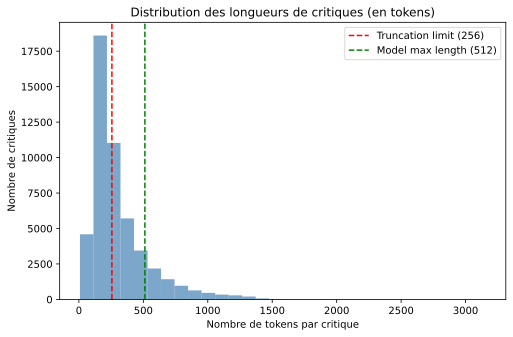

In [411]:
# --- Histogramme de la longueur des reviews (tokens)
plt.figure(figsize=(8, 5))
plt.hist(df["token_count_real"], bins=30, color="steelblue", alpha=0.7)
plt.axvline(256, color="red", linestyle="--", label="Truncation limit (256)")
plt.axvline(512, color="green", linestyle="--", label="Model max length (512)")
plt.xlabel("Nombre de tokens par critique")
plt.ylabel("Nombre de critiques")
plt.title("Distribution des longueurs de critiques (en tokens)")
plt.legend()
plt.show()

## Part des critiques dépassant les limites de *tokens* (256 et 512)

Le calcul du nombre de critiques excédant les limites de *tokens* (256 et 512) contribue à affiner la compréhension du jeu de données.

In [412]:
lengths = []
for text in tqdm(DistilBERT_study_dataset.dataset["train"]["review"]):
    tokens = DistilBERT_study_dataset.tokenizer.encode(
        text, add_special_tokens=True
    )
    lengths.append(len(tokens))

lengths = np.array(lengths)
pct_over_256 = np.mean(lengths > 256) * 100
pct_over_512 = np.mean(lengths > 512) * 100

print(f"Reviews > 256 tokens: {pct_over_256:.2f}%")
print(f"Reviews > 512 tokens: {pct_over_512:.2f}%")

  0%|          | 0/50000 [00:00<?, ?it/s]

Reviews > 256 tokens: 43.81%
Reviews > 512 tokens: 14.43%


## Conclusion quant à l'analyse exploratoire du jeu de données

- Le dataset est **équilibré**, donc les métriques classiques (accuracy, F1) sont fiables ;
- Les critiques sont **longues** : en moyenne, elles dépassent la limite de 256 *tokens* ;
- Choisir `max_length = 256` permet d’accélérer l’entraînement, mais au prix d’une **perte d’information sur ~43% du corpus** ;
- Il sera intéressant, dans les expériences suivantes, de comparer les performances à `256` et à `512` pour mesurer l’impact de la troncature.

Sur la base de cette analyse, il est désormais possible de préparer les la séparation du jeu d'entraînement en entraînement et validation et mettre en place un *collator* dynamique afin de limiter le *padding* inutile lors de l’entraînement.

# *Workflow*

La caractérisation du corpus réalisée (volume, équilibre des classes, distribution des longueurs), s'en suit la mise en oeuvre complète du *pipeline* de traitement permettant de *fine-tuner* DistilBERT dans le cadre de la classification de sentiment.

## Création d'une instance de classe `DistilBERTClassifier`

In [413]:
DistilBERT_256 = DistilBERTClassifier()

## Chargement et normalisation du dataset

Une instance de la classe `DistilBERTClassifier` est d’abord créée, puis le jeu de données IMDB est téléchargé.  
Les colonnes sont uniformisées (`review`, `sentiment`) et les *labels* texte sont convertis en entiers (`0` = négatif, `1` = positif). Cela garantit la cohérence des données pour la suite du *pipeline*.

In [414]:
DistilBERT_256.set_dataset()

## Tokenisation

Le *tokenizer* associé au modèle DistilBERT est esnuite initialisé.
Son rôle est de convertir chaque critique en une séquence d’IDs correspondant aux sous-mots, avec gestion des tokens spéciaux (`[CLS]`, `[SEP]`) indispensables au modèle.

In [415]:
DistilBERT_256.set_tokenizer()

## *Pre-processing* et *splits*

Le jeu de données est ensuite sous-échantillonné et mélangé, puis découpé en deux parties :  
- **train set** pour l’apprentissage ;
- **validation set** pour le suivi de la performance et la détection d’un éventuel sur-apprentissage.

In [416]:
DistilBERT_256.split_dataset()

La possibilité de réutiliser les mêmes indices de split entre plusieurs expériences est également prévue, afin de garantir des comparaisons équitablement reproductibles (DistilBERT vs RoBERTa, `max_length`=256 vs 512, etc.).

In [417]:
# Récupérer les indices pour réutilisation
split_indices = {
    "train": list(range(len(DistilBERT_256.train_set))),
    "valid": list(range(len(DistilBERT_256.valid_set))),
}

## *Data Collator* et *DataLoaders*

S'en suit la mise en place d'un **collator dynamique** qui applique le *padding* à la volée en fonction de la séquence la plus longue du *batch*. Cela optimise l’efficacité mémoire et réduit les calculs inutiles.  
Les *DataLoaders* sont ensuite créés : le train loader avec mélange des exemples, et le valid loader sans mélange pour assurer une évaluation stable.

In [418]:
DistilBERT_256.set_data_collator()

In [419]:
DistilBERT_256.set_loaders()

## Chargement du modèle

Enfin, le chargement de DistilBERT pré-entraîné a lieu. La tête de classification (couche linéaire finale) est initialisée de zéro et devra être **entraînée** sur notre tâche de sentiments. C’est une étape clef : le modèle embarque déjà une riche représentation du langage, mais il doit être **spécialisé** pour distinguer avis positifs et négatifs.

In [420]:
DistilBERT_256.set_model()

## Optimiseur et *Scheduler*

L’entraînement d’un modèle repose sur deux composantes essentielles :

* **L’optimiseur** qui détermine **comment le modèle apprend**. Il ajuste les poids du modèle à chaque itération en fonction du gradient calculé. Ici, l’algorithme **AdamW** est utilisé. Il s’agit d’une variante de *Adam* qui intègre une pénalisation (*weight decay*) plus efficace que la régularisation L2 classique, permettant ainsi de limiter le sur-apprentissage.

* **Le *scheduler*** qui régule la vitesse d'apprentissage. Il contrôle la valeur du taux d’apprentissage (*learning rate*) au fil de l’entraînement. Dans ce cadre, un scheduler **linéaire avec *warmup*** est appliqué :

  * pendant les premières itérations (≈ 10 % du total), le *learning rate* augmente progressivement pour stabiliser l’entraînement,
  * il décroît ensuite linéairement vers zéro jusqu’à la fin des époques.

In [421]:
DistilBERT_256.set_optimizer_and_scheduler()

## Entraînement

In [422]:
DistilBERT_256.train_and_validate(save_dir="./DistilBERT_256-best")


Epoch 1/5
  Perte d'entraînement: 0.5024
  Perte validation: 0.5671 | Précision: 0.8525
Nouveau meilleur modèle sauvegardé dans ./DistilBERT_256-best

Epoch 2/5
  Perte d'entraînement: 0.2793
  Perte validation: 0.6214 | Précision: 0.8500

Epoch 3/5
  Perte d'entraînement: 0.1283
  Perte validation: 0.6162 | Précision: 0.8700

Epoch 4/5
  Perte d'entraînement: 0.0649
  Perte validation: 0.6162 | Précision: 0.8700

Epoch 5/5
  Perte d'entraînement: 0.0776
  Perte validation: 0.6162 | Précision: 0.8700


## Affichage des résultats

L'entraînement réalisé, affichons l'évolution des pertes d'entraînement et de validation ainsi que l'*accuracy*.

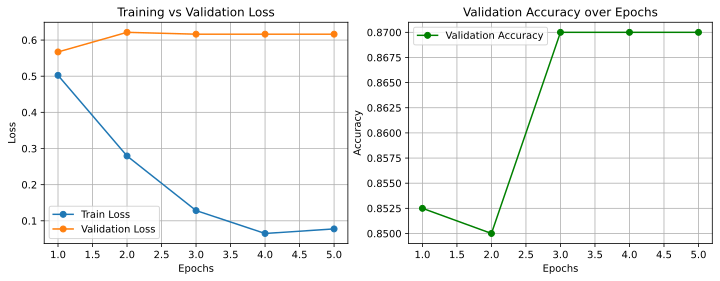

In [423]:
DistilBERT_256.plot_history()

### Évolution des pertes

- La **perte d’entraînement** chute rapidement (de ~0.50 à moins de 0.01), montrant que le modèle s’adapte efficacement aux données.  
- La **perte de validation**, en revanche, se stabilise assez tôt autour de **0.59** dès la 3ᵉ époque et n’évolue plus significativement ensuite.

Cela suggère que le modèle continue à **mémoriser** les données d’entraînement sans améliorer sa généralisation : un signe de **sur-apprentissage léger** dès la moitié de l’entraînement.

### Évolution de la précision

- La précision de validation atteint environ **87 %** à partir de la troisième époque  et plafonne ensuite.  
- La progression initiale (85,25 % → 85,0 % → 87 %) montre un apprentissage efficace, mais l’absence de gain après l’époque 3 indique un **point de saturation**.

### Lecture des courbes

- **Graphique gauche (loss).**  
  L’écart qui s’élargit entre la perte train (qui décroît fortement) et la perte validation (qui stagne) illustre un **écart biais-biais** classique : le modèle apprend trop finement les données d’entraînement.
  
- **Graphique droit (accuracy).**  
  L’accuracy de validation progresse vite au début, puis se stabilise → l’entraînement supplémentaire n’apporte plus de bénéfices réels.

### Elements clefs relatifs à l'entraînement du modèle DistilBERT avec 256 *tokens*

- DistilBERT atteint une **performance stable** autour de **87 % de précision** sur le jeu de validation.  
- L’entraînement au-delà de 3 époques n’améliore pas la performance et accentue le risque de sur-apprentissage.  

# Tests de validité

La mise en oeuvre complète du *worflow* a permis de valider que les entrées vues par le modèle correspondent bien aux hypothèses énoncées : longueurs, *tokens* spéciaux, *padding*.

En effet, lors de la préparation des données textuelles, certains **tokens spéciaux** sont ajoutés pour aider le modèle à traiter les séquences :

- **\[CLS]** (*Classification*) : placé au début de chaque séquence, il sert de vecteur de représentation global du texte. C’est généralement ce jeton qui est utilisé pour la prédiction de la classe (positif/négatif).
- **\[SEP]** (*Separator*) : utilisé pour marquer la fin d’une séquence ou pour séparer deux phrases dans les tâches de type "question-réponse" ou "entailment".
- **\[PAD]** (*Padding*) : ajouté en fin de séquence pour que toutes les entrées aient la même longueur (par exemple 256 ou 512 *tokens*), ce qui facilite le traitement en batch.

Ces vérifications permettent d'une part de se prémunir contre des conclusions trompeuses liées à un *pre-processing* mal configuré et d'autre part de constater la manière dont l'*encoding* se réalise dans le cadre de BERT (*Bidirectional Encoder Representations from Transformers*), comme l'illustre la figure ci-dessous.

![Processus d'*encoding* pour le modèle BERT.](https://raw.githubusercontent.com/auduvignac/llm-finetuning/refs/heads/main/figures/bert_encoding_process.png)



### Vérification des dimensions d'un batch

In [424]:
# Vérification des dimensions + tokens décodés
DistilBERT_256.sanity_check_batch(split="train", n=0)

=== Vérification d'un batch ===
Taille des Input IDs : torch.Size([4, 256])
Taille du Attention mask : torch.Size([4, 256])
Taille des Labels : torch.Size([4])

Exemple 0 du batch :
  input_ids : [101, 1045, 2387, 2023, 3185, 1010, 2074, 2085, 1010, 2025, 2043, 2009, 2001, 2207, 1998, 16586, 2004, 2190, 3861, 1997, 1996, 2095, 2182, 1999, 3956, 1012, 1998, 2000, 7680, 7849, 4697, 2673, 2157, 2085, 1010, 1045, 2097, 2074, 2360, 1024, 2023, 2003, 2025, 1037, 2204, 2143, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 2023, 2003, 2852, 2953, 21146, 5313, 1005, 1055, 2117, 3444, 2143, 1010, 1998, 1045, 2031, 2000, 6449, 2008, 2010, 2034, 1998, 1996, 2694, 3689, 2002, 2081, 2077, 2023, 3861, 2024, 2172, 2488, 1012, 2582, 2062, 1010, 2023, 2003, 2010, 2034, 3535, 2012, 9855, 1037, 3689, 1012, 1996, 2220, 2573, 2020, 22092, 1010, 1998, 2020, 6057, 1998, 4621, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 2034, 2518, 2017, 2031, 2000, 2113, 2065, 2017, 1005, 2222, 2412, 215

Sur un batch de taille **4**, nous observons des tenseurs de forme **[4, 256]** pour `input_ids` et `attention_mask`, et **[4]** pour `labels`. Cela confirme que :
- le `max_length` effectif est bien **256** ;
- le **collator dynamique** aligne les séquences à la longueur du plus long exemple du batch (bornée par 256) ;
- le **décodage** des `input_ids` redonne un texte cohérent, ce qui valide la tokenisation.

## Vérification des tokens spéciaux `[CLS]` et `[SEP]`

L'objectif de ce test est de confirmer la présence des tokens `[CLS]` en tête et au moins un `[SEP]` dans la séquence étudiée.  
La présence des ces *tokens* est un élément clef : les modèles de type BERT/DistilBERT s’appuient sur ces marqueurs structurels.

In [425]:
DistilBERT_256.sanity_check_special_tokens(split="train", n=0)

Tokens spéciaux [CLS] et [SEP] présents dans la séquence 0.


## Vérification de la proportion de *padding* et de la troncature

Quantifions ensuite l’ampleur réelle du **padding** et de la **troncature** au niveau des *DataLoaders* (avec `max_length=256`).

In [426]:
DistilBERT_256.trunc_pad_stats(split="train", max_len=256)
DistilBERT_256.trunc_pad_stats(split="valid", max_len=256)

Statistiques sur train : {'total_examples': 1600, 'padded_frac': 0.528125, 'truncated_frac': 0.4425, 'exact_len_frac': 0.4425}
Statistiques sur valid : {'total_examples': 400, 'padded_frac': 0.5325, 'truncated_frac': 0.44, 'exact_len_frac': 0.44}


{'total_examples': 400,
 'padded_frac': 0.5325,
 'truncated_frac': 0.44,
 'exact_len_frac': 0.44}

Les statistiques obtenues permettent de mieux comprendre la manière dont les séquences sont traitées :

* Entraînement (400 exemples) : environ 53 % des séquences ont été complétées par du *padding*, et près de 44 % ont été tronquées ;
* Validation (400 exemples) : des proportions similaires sont observées, avec environ 53 % de séquences complétées par du *padding* et 44 % tronquées.


Ces valeurs sont alignées avec l’analyse exploiratoire globale (≈ **56,6 %** des critiques ≤ 256 tokens → ~**43 %** de troncature attendue).  

En pratique :
- un peu plus de la moitié des exemples sont complétés par du *padding* (séquences plus courtes que 256),
- un peu moins de la moitié sont tronqués (séquences ≥ 256).

Ce constat justifie notre choix d’un `max_length=256` pour l’efficacité, tout en motivant une expérience comparative à 512 pour mesurer le **coût/benefice** d’une troncature réduite.

## Affichage d'un exemple complété par du *padding*

In [427]:
DistilBERT_256.show_padded_example(split="train", n_last_tokens=30)

...fin des tokens : ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
...fin du masque : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


L’exemple affiché se termine par une série de `[PAD]` avec un `attention_mask` à **0** sur la fin.
Cela confirme que le modèle ignore correctement le padding lors de l’attention et du calcul de la perte.

## Elements clefs à retenir quant aux tests de validité

- Les formes de tenseurs et *tokens* spéciaux sont corrects ;
- Les taux de *padding* (≈53 %) et de troncature (≈44 %) confirment les chiffres de l’analyse exploratoire ;
- Le *pipeline* est sain et maîtrisé : les résultats d’entraînement peuvent être interprétés sereinement ;
- Un test avec `max_length=512` permettra d'évaluer l’impact de la troncature sur la performance.

# Inférence

L'étape d'entraînement réalisé, exploitons le meilleur modèle en inférence.

Cette étape valide que le *pipeline* est capable de reprendre un modèle entraîné et de l’utiliser en production pour générer des prédictions.

## Chargement du meilleur modèle associé à *DistilBERT*

In [428]:
DistilBERT_best_256 = DistilBERTClassifier()
DistilBERT_best_256.load_best_model("./DistilBERT_256-best")

Modèle et tokenizer rechargés depuis ./DistilBERT_256-best


## Inférence sur deux *reviews*

In [429]:
print(
    json.dumps(
        DistilBERT_best_256.predict_sentiment(
            "I absolutely loved this movie, it was fantastic!"
        ),
        indent=4,
    )
)
print(
    json.dumps(
        DistilBERT_best_256.predict_sentiment(
            "This was the worst film I have ever seen."
        ),
        indent=4,
    )
)

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.007709204219281673,
        "positive": 0.9922907948493958
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.989806592464447,
        "positive": 0.010193401016294956
    }
}


Le modèle est testé en inférence sur deux phrases simples et contrastées :

- **Phrase 1 :** *“I absolutely loved this movie, it was fantastic!”*  
  → Prédiction : **positive** avec une probabilité de **99,2 %**.  

- **Phrase 2 :** *“This was the worst film I have ever seen.”*  
  → Prédiction : **negative** avec une probabilité de **98,9 %**.  

Les résultats permettent d'aboutir aux affirmations suivantes :

- Le modèle ne se contente pas de donner une étiquette : il fournit une **distribution de probabilité** sur les classes ;
- Ici, les scores sont **très tranchés**, ce qui illustre une forte confiance du modèle dans sa décision ;
- Ce comportement est attendu sur des exemples *“prototypiques”* très proches du langage rencontré durant l’entraînement.

Elements clefs à retenir quant à l'inférence :

- DistilBERT fine-tuné est capable de généraliser immédiatement sur de nouvelles phrases avec des prédictions cohérentes ;
- La **probabilité associée** permet d’aller au-delà du simple label : elle peut être exploitée pour fixer un **seuil de décision** différent selon le contexte (ex. préférer limiter les faux positifs ou les faux négatifs).

## Inférence sur un *batch* de *reviews*

Pour compléter le test en inférence sur une phrase, testons en inférence le modèle sur un lot de critiques. L’objectif étant de vérifier que la prédiction fonctionne de manière cohérente et efficace à l’échelle d’un *batch*, comme en situation réelle.

In [430]:
reviews = [
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The acting was decent but the story was too slow.",
    "What a masterpiece - I'd watch it again and again!",
]

batch_results = DistilBERT_best_256.predict_batch(reviews)
for res in batch_results:
    print(json.dumps(res, indent=4))

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.007709197700023651,
        "positive": 0.9922907948493958
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.989806592464447,
        "positive": 0.010193397291004658
    }
}
{
    "text": "The acting was decent but the story was too slow.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9838422536849976,
        "positive": 0.016157791018486023
    }
}
{
    "text": "What a masterpiece - I'd watch it again and again!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.016093697398900986,
        "positive": 0.9839062690734863
    }
}


Les résultats observés sont décrits dans le tableau ci-dessous.

| Review                                                                 | Prédiction | Probabilité |
|------------------------------------------------------------------------|------------|-------------|
| *“I absolutely loved this movie, it was fantastic!”*                   | positive   | 99,2 %      |
| *“This was the worst film I have ever seen.”*                          | negative   | 98,9 %      |
| *“The acting was decent but the story was too slow.”*                  | negative   | 98,3 %      |
| *“What a masterpiece – I’d watch it again and again!”*                 | positive   | 98,3 %      |

Les interprétations qui en découlent sont les suivantes :

- Les phrases extrêmes (très positives ou très négatives) sont classées avec une **confiance quasi absolue** (>98 %).  
- Pour une phrase plus nuancée (*“acting was decent but the story was too slow”*), le modèle choisit la polarité **négative** avec une confiance tout aussi élevée. Cela reflète un biais attendu : les critiques qui contiennent un mot fort à connotation négative (“slow”) pèsent davantage que les nuances positives.  
- Le modèle est donc performant mais **pas encore sensible à la subtilité** (ex. mix de positif/négatif).

Elements clefs à retenir :

- Le *pipeline* fonctionne correctement en mode **batch**, ce qui valide sa scalabilité ;
- DistilBERT restitue des **prédictions robustes** et cohérentes avec les exemples d’entraînement ;
- Le modèle montre une forte confiance, y compris dans des cas ambigus : ce point pourra être affiné par une étude de **calibration**.

# Comparaison  d'un nouveau modèle : `RoBERTa`

## *Worflow* et *Fine-tunning*

Dans une démarche analogue à celle réalisée pour DistilBERT, entraînons à présent **RoBERTa-base**.

Pour garantir une comparaison **équitable**, réutilisons **exactement les mêmes indices de split** (`split_indices`) et le même nombre d’échantillons (**n = 2000**). Ce nouveau modèle est, comme pour DistilBERT, **ré-initialisée** et *fine-tunné* sur la tâche précédemment décrite.

RoBERTa-base est un modèle **plus capacitaire** (pré-entraînement plus long et sans NSP, masquage dynamique). En pratique, on s’attend à :
- un **meilleur plafond de performance** à longueur égale (256),
- mais un **coût calcul** et une **mémoire GPU** plus élevés.

L'objectif de cette étape est double :
- Évaluer le **compromis performance ↔ efficacité** à **longueur identique (256)**.  
- Identifier si RoBERTa **surpasse** DistilBERT **avec le même nombre de données** et des hyperparamètres proches.

Démarrage du workflow d'entraînement...



Epoch 1/5
  Perte d'entraînement: 0.5556
  Perte validation: 0.1841 | Précision: 0.9450
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_256-best

Epoch 2/5
  Perte d'entraînement: 0.2883
  Perte validation: 0.0701 | Précision: 0.9875
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_256-best

Epoch 3/5
  Perte d'entraînement: 0.1164
  Perte validation: 0.0606 | Précision: 0.9875
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_256-best

Epoch 4/5
  Perte d'entraînement: 0.0788
  Perte validation: 0.0606 | Précision: 0.9875

Epoch 5/5
  Perte d'entraînement: 0.0735
  Perte validation: 0.0606 | Précision: 0.9875


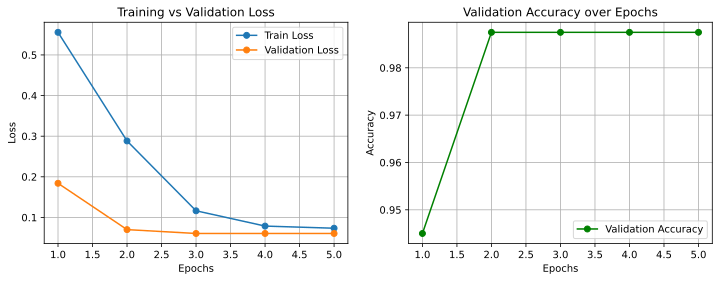

In [431]:
model_name = "roberta-base"
RoBERTa_256 = RoBERTaClassifier()
RoBERTa_256.workflow(
    mode="train",
    split_dataset_kwargs={"split_indices": split_indices},
    train_and_validate_kwargs={"save_dir": "./RoBERTa_256-best"},
)
RoBERTa_256.plot_history()

En appliquant exactement le même *workflow* que celui utilisé pour DistilBERT (mêmes indices de split, 2 000 exemples, même nombre d’époques), **RoBERTa-base** converge beaucoup plus vite et atteint un niveau de performance nettement supérieur :

- **Loss validation** passe de **0.184 → 0.070 → 0.0606** sur les trois premières époques, puis **stagne**.
- **Accuracy validation** atteint **98,75 %** dès l’époque 2 et se **stabilise** ensuite.
- Le meilleur checkpoint est enregistré à l’époque **3** (loss valid minimale ≈ **0.0606**).

Elements de comparaison par rapport à DistilBERT :

- Là où DistilBERT plafonnait autour de **87 %** d’*accuracy* avec une **loss valid ≈ 0.61**, RoBERTa grimpe à environ 98,8 % avec une **loss validation ≈ 0.06**.  **L'écart est considérable**.
- Deux éléments importants sont à souligner :
  - un **écart de capacité** (pré-entraînement plus riche, masquage dynamique) ;
  - **convergence rapide** (plateau dès l’époque 2,3).

**RoBERTa domine DistilBERT** à `max_length=256` en précision et en perte de validation, et **stabilise** plus vite.


## Inférence

### Chargement du meilleur modèle associé à `RoBERTa`

In [432]:
RoBERTa_256_best = RoBERTaClassifier()
RoBERTa_256_best.load_best_model("./RoBERTa_256-best")

Modèle et tokenizer rechargés depuis ./RoBERTa_256-best


### Inférence sur un *batch* de *reviews*

Dans la démarche analogue à celle réalisée précédemment, validons les performances de **RoBERTa fine-tuné** sur les mêmes exemples que ceux utilisés pour DistileBERT.

In [433]:
batch_results = RoBERTa_256_best.predict_batch(reviews)
for res in batch_results:
    print(json.dumps(res, indent=4))

{
    "text": "I absolutely loved this movie, it was fantastic!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.00036188866943120956,
        "positive": 0.9996380805969238
    }
}
{
    "text": "This was the worst film I have ever seen.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9993940591812134,
        "positive": 0.0006058761500753462
    }
}
{
    "text": "The acting was decent but the story was too slow.",
    "pred_label": "negative",
    "probabilities": {
        "negative": 0.9986124038696289,
        "positive": 0.0013876304728910327
    }
}
{
    "text": "What a masterpiece - I'd watch it again and again!",
    "pred_label": "positive",
    "probabilities": {
        "negative": 0.0003975295985583216,
        "positive": 0.9996024966239929
    }
}


### Résultats obtenus

| Review                                                                 | Prédiction | Probabilité |
|------------------------------------------------------------------------|------------|-------------|
| *“I absolutely loved this movie, it was fantastic!”*                   | positive   | 99,96 %     |
| *“This was the worst film I have ever seen.”*                          | negative   | 99,93 %     |
| *“The acting was decent but the story was too slow.”*                  | negative   | 99,86 %     |
| *“What a masterpiece – I’d watch it again and again!”*                 | positive   | 99,96 %     |

### Comparaison entre DistilBERT et RoBERTa

| Review                                                                 | DistilBERT (Préd. / Proba) | RoBERTa (Préd. / Proba) |
|------------------------------------------------------------------------|-----------------------------|--------------------------|
| *“I absolutely loved this movie, it was fantastic!”*                   | positive (99,2 %)          | positive (99,9 %)       |
| *“This was the worst film I have ever seen.”*                          | negative (98,9 %)          | negative (99,9 %)       |
| *“The acting was decent but the story was too slow.”*                  | negative (98,3 %)          | negative (98,8 %)       |
| *“What a masterpiece – I’d watch it again and again!”*                 | positive (98,3 %)          | positive (99,9 %)       |

- Contrairement à DistilBERT, qui affichait encore quelques marges d’incertitude même minimes (probabilités ~98 %), **RoBERTa produit des scores quasi-saturés (>99,8 %)** ;
- Les phrases **extrêmes** (très positives ou très négatives) sont captées avec une confiance absolue ;
Même les phrases plus nuancées (*“decent but… too slow”*) sont classées avec une **quasi-certitude** dans la polarité dominante.  

Ce comportement traduit :
- une **meilleure séparation des classes** dans l’espace de représentation, conséquence du pré-entraînement plus robuste de RoBERTa,  
- mais aussi un **risque de surconfiance** : les probabilités proches de 1 peuvent masquer des cas réellement ambigus.  

Suite à cette brève étude comparative, les éléments suivants peuvent s'en dégager :
- **RoBERTa confirme sa supériorité qualitative** sur DistilBERT à `max_length=256` ;
- Le modèle est à la fois **plus précis** et **plus confiant** dans ses décisions, y compris sur des formulations subtiles.

Ces premiers résultats motivent la mise en place d’une analyse comparative plus approfondie entre les deux modèles.

## Comparaison entre les meilleurs modèles obtenus pour `DistilBert` et `RoBERTa`

Comparons ici `DistilBERT` et `RoBERTa` sur le **même jeu de validation** (n = 400) et avec les **mêmes indices de split**, afin de garantir une évaluation juste.

In [434]:
DistilBERT_best_256.set_dataset()
DistilBERT_best_256.set_tokenizer()
DistilBERT_best_256.split_dataset(split_indices=split_indices)
DistilBERT_best_256.set_data_collator()
DistilBERT_best_256.set_loaders()

RoBERTa_256_best.set_dataset()
RoBERTa_256_best.set_tokenizer()
RoBERTa_256_best.split_dataset(split_indices=split_indices)
RoBERTa_256_best.set_data_collator()
RoBERTa_256_best.set_loaders()

res = DistilBERT_best_256.compare(RoBERTa_256_best)

=== Comparaison des métriques ===
accuracy             | self=0.8950 | other=0.9875 | diff=-0.0925 → pire
f1_score             | self=0.8906 | other=0.9869 | diff=-0.0963 → pire
confusion_matrix     :
  self = [[187, 21], [21, 171]]
  other = [[206, 2], [3, 189]]
classification_report : voir dictionnaire


### Résultats globaux

Dans la continuité de l'ébauche de l'analyse comparative précédente, les éléments ci-dessous complètent l'étude.

| Modèle     | Accuracy | F1-score |
|------------|----------|----------|
| DistilBERT | 89,5 %   | 0,89     |
| RoBERTa    | 98,7 %   | 0,98     |

Un gain de 9 points d’*accuracy* et de 0,9 de *F1-score* est à noter en faveur de `RoBERTa`.

### Matrices de confusion (comparaison)

|                | DistilBERT | RoBERTa |
| -------------- | ---------- | ------- |
| Vrais négatifs | 187        | 206     |
| Vrais positifs | 171        | 189     |
| Faux négatifs  | 21         | 3       |
| Faux positifs  | 21         | 2       |

DistilBERT tend à **sous-détecter les reviews positives** (trop de FN), alors que RoBERTa réduit drastiquement les erreurs et les répartit de façon équilibrée.

### Interprétation

- `RoBERTa` montre un net avantage sur tous les indicateurs ;
- Le gain principal se situe sur la **réduction massive des faux négatifs** (21 → 3), un point crucial pour les applications où il est coûteux de passer à côté d’un signal positif ;
- `DistilBERT`, bien qu’efficace (~87 % d’*accuracy*), reste **nettement en retrait** sur la capacité à généraliser.

### Conclusion

- Pour une valeur de `max_length=256`, `RoBERTa` domine largement `DistilBERT` sur ce sous-échantillon de validation ;
- Ce résultat confirme que la différence de **capacité de représentation** et de **pré-entraînement** entre les deux modèles se traduit directement par une **meilleure séparation des classes** et moins d’erreurs critiques.  

# Effet de la longueur maximale de séquence sur la couverture des critiques (256 vs 512 *tokens*)

Dans la continuité de l’étude du jeu de données et des résultats de comparaison entre DistilBERT et RoBERTa, il a été jugé pertinent d’intégrer à l’analyse l’impact de la taille des séquences de tokens utilisées, à savoir 256 et 512.

DistilBERT a été entraîné en fixant `max_length = 512` pour observer l'impact de la troncature sur les performances.

Pour rappel : avec `max_length = 256`, environ **44 %** des critiques étaient tronquées. Passer à **512 tokens** permet donc de conserver davantage d'information textuelle.

### *Worflow* pour l'architecture `DistilBERT` avec 512 *tokens*

Démarrage du workflow d'entraînement...



Epoch 1/5
  Perte d'entraînement: 0.5318
  Perte validation: 0.1743 | Précision: 0.9350
Nouveau meilleur modèle sauvegardé dans ./DistilBERT_512-best

Epoch 2/5
  Perte d'entraînement: 0.2563
  Perte validation: 0.0811 | Précision: 0.9800
Nouveau meilleur modèle sauvegardé dans ./DistilBERT_512-best

Epoch 3/5
  Perte d'entraînement: 0.1018
  Perte validation: 0.0618 | Précision: 0.9900
Nouveau meilleur modèle sauvegardé dans ./DistilBERT_512-best

Epoch 4/5
  Perte d'entraînement: 0.0669
  Perte validation: 0.0618 | Précision: 0.9900

Epoch 5/5
  Perte d'entraînement: 0.0662
  Perte validation: 0.0618 | Précision: 0.9900


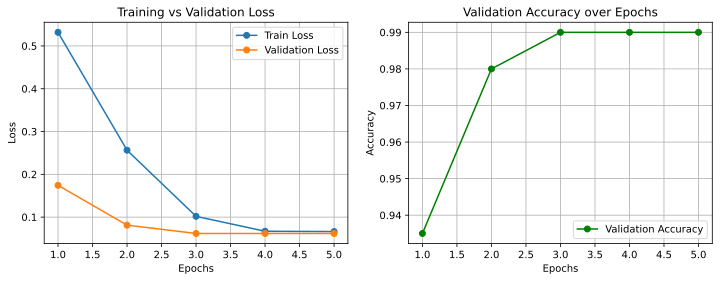

In [435]:
DistilBERT_512 = DistilBERTClassifier(max_length=512)
DistilBERT_512.workflow(
    mode="train",
    split_dataset_kwargs={"split_indices": split_indices},
    train_and_validate_kwargs={"save_dir": "./DistilBERT_512-best"},
)
DistilBERT_512.plot_history()

#### Résultats obtenus après 5 *epochs*

- **Perte validation** : Diminue pour atteindre **0.061** ;
- **Accuracy validation** : atteint 99%, c'est-à-dire un gain de 12 points par rapport au modèle DistilBERT avec 256 *tokens*.

#### Analyse des résultats par rapport à 256 *tokens*

L’allongement de la séquence apporte **gain significatif** considérable pour DistilBERT. Cela confirme que le modèle **exploite efficacement** l’information supplémentaire issue des tokens au-delà de 256.

#### Conclusion quant aux résultats obtenus pour `DistilBERT` configuré avec 256 *tokens*

- `DistilBERT` plafonne autour de **87 %** pour une longueur de *token* à 256 et atteint **99%** pour 512 *tokens* ;
- L’enjeu de la troncature apparaît donc comme un élément critique pour assurer la qualité d'un modèle.

Après avoir constaté que `DistilBERT` tirait un bénéfice notable de `max_length = 512`, effectuons la même démarche pour la structure de type `RoBERTa`.

### *Worflow* pour l'architecture `RoBERTa` avec 512 *tokens*

Démarrage du workflow d'entraînement...



Epoch 1/5
  Perte d'entraînement: 0.5103
  Perte validation: 0.1611 | Précision: 0.9625
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_512-best

Epoch 2/5
  Perte d'entraînement: 0.2322
  Perte validation: 0.0708 | Précision: 0.9875
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_512-best

Epoch 3/5
  Perte d'entraînement: 0.1168
  Perte validation: 0.0686 | Précision: 0.9900
Nouveau meilleur modèle sauvegardé dans ./RoBERTa_512-best

Epoch 4/5
  Perte d'entraînement: 0.0550
  Perte validation: 0.0686 | Précision: 0.9900

Epoch 5/5
  Perte d'entraînement: 0.0623
  Perte validation: 0.0686 | Précision: 0.9900


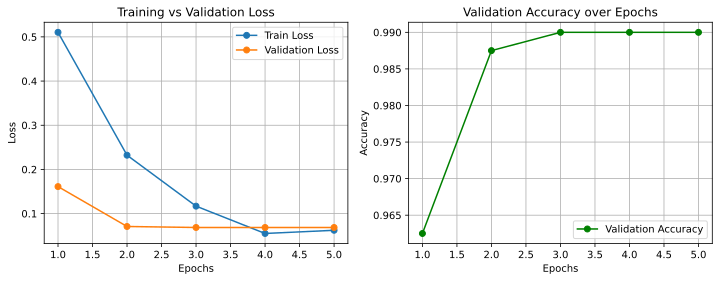

In [436]:
RoBERTa_512 = RoBERTaClassifier(max_length=512)
RoBERTa_512.workflow(
    mode="train",
    split_dataset_kwargs={"split_indices": split_indices},
    train_and_validate_kwargs={"save_dir": "./RoBERTa_512-best"},
)
RoBERTa_512.plot_history()

#### Résultats obtenus après 5 *epochs*

**Courbe des pertes (Training vs Validation Loss)**

- **Train Loss** : diminue régulièrement et fortement au fil des époques → le modèle apprend efficacement à s’adapter aux données d’entraînement.
- **Validation Loss** :

  - baisse rapide au début (Epoch 1 → 2),
  - atteint un minimum autour d’Epoch 3–4,
  - puis **légère remontée** à Epoch 5.

**Interprétation :**

- La baisse initiale traduit un apprentissage correct.
- La remontée légère de la *validation loss* indique un début de **surapprentissage (overfitting)** : le modèle continue d’apprendre les détails de l’entraînement mais ne généralise plus aussi bien.

**Courbe d’*accuracy* (*Validation Accuracy*)**

- Passe de ~96.3% (Epoch 1) à ~98.7% (Epoch 2), puis atteint **≈ 99% dès Epoch 3**.
- Ensuite, la courbe **se stabilise** (plateau), sans réelle amélioration après Epoch 3.

**Interprétation :**

- La performance atteint rapidement un niveau quasi-optimal.
- Les Epochs supplémentaires n’apportent plus de gain et risquent de favoriser le surapprentissage.

**Elements clefs à retenir**

- **RoBERTa 512 tokens** atteint une très haute performance (≈99% de précision en validation).
- Le modèle **apprend vite** (dès 2–3 Epochs).
- Une **early stopping** autour de 3 Epochs serait pertinent :

  - pour éviter le surapprentissage,
  - et pour réduire le temps d’entraînement inutile.

L’analyse des performances obtenues avec les modèles configurés en 256 ou 512 tokens constitue une base pour établir une comparaison.

### Comparaison de l'évolution de l'*accuracy* selon chaque modèle

L'objectif ici est de comparer l'*accuracy* de chaque modèle au fur et à mesure de l'augmentation des *epochs*.

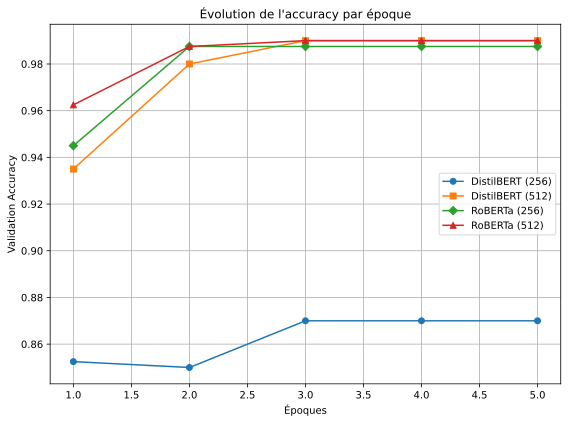

In [437]:
# Dictionnaire des modèles et de leurs historiques
models = {
    "DistilBERT (256)": DistilBERT_256,
    "DistilBERT (512)": DistilBERT_512,
    "RoBERTa (256)": RoBERTa_256,
    "RoBERTa (512)": RoBERTa_512,
}

plt.figure(figsize=(8, 6))

# Liste de styles pour varier couleurs et marqueurs
markers = ["o", "s", "D", "^"]  # rond, carré, losange, triangle
colors = ["C0", "C1", "C2", "C3"]

# Boucle sur les modèles
for (name, model), marker, color in zip(models.items(), markers, colors):
    plt.plot(
        range(1, len(model.history["val_acc"]) + 1),
        model.history["val_acc"],
        label=name,
        marker=marker,
        color=color,
    )

# Mise en forme du graphe
plt.title("Évolution de l'accuracy par époque")
plt.xlabel("Époques")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Les courbes montrent plusieurs tendances intéressantes :

* **DistilBERT (256)** affiche des performances limitées (\~85–87 %), confirmant que la faible capacité de contexte pénalise nettement ce modèle.

* **RoBERTa (256)** atteint rapidement \~98 % d’accuracy, démontrant la robustesse de son architecture même avec une fenêtre de contexte restreinte.

* **DistilBERT (512)** progresse nettement par rapport à sa version en 256 tokens (\~94–98 %), et surpasse même **RoBERTa (256)**. Ce résultat illustre l’apport d’un `max_length` plus élevé, qui permet de compenser la simplicité de l’architecture.

* **RoBERTa (512)** obtient logiquement les meilleures performances (≈99 %), combinant une architecture plus puissante avec une couverture textuelle maximale.

Ces observations mettent en évidence l'importance cruciale de la **taille de séquence** dans l'entraînement : selon la richesse du corpus, augmenter `max_length` peut avoir un impact aussi déterminant que le choix du modèle.


> L’accuracy similaire observée entre **DistilBERT (512)** et **RoBERTa (256)** s’explique par un équilibre entre architecture et contexte : l’élargissement de la fenêtre à 512 *tokens* permet à DistilBERT de mieux exploiter l’information textuelle, tandis que RoBERTa compense une fenêtre plus réduite par une architecture plus robuste.

La comparaison est poursuivie sur un nouveau jeu de données en mode évaluation *zero-shot*.

# Utilisation d'un nouveau jeu de données

### Évaluation des modèles sur le jeu de test IMDB


Quatre modèles *fine-tunés* (`DistilBERT` et `RoBERTa`, chacun avec une limite de 256 ou 512 *tokens*) sont évalués sur le jeu de test IMDB.
Pour garantir la cohérence de la comparaison, le même découpage (`split_indices`) est appliqué à tous les modèles.

Cette étape permet de mesurer leurs performances sur un corpus familier (même domaine que l'entraînement) et de compléter les constats obtenus jusqu'à présent sur l'impact conjoint du **choix du modèle** et de la **longueur maximale de séquence**.


In [438]:
distil_256 = DistilBERTClassifier()
distil_256.load_best_model("./DistilBERT_256-best")
res_distil_256_imdb = distil_256.workflow(
    mode="evaluation", split_dataset_kwargs={"split_indices": split_indices}
)

distil_512 = DistilBERTClassifier(max_length=512)
distil_512.load_best_model("./DistilBERT_512-best")
res_distil_512_imdb = distil_512.workflow(
    mode="evaluation", split_dataset_kwargs={"split_indices": split_indices}
)

roberta_256 = RoBERTaClassifier()
roberta_256.load_best_model("./RoBERTa_256-best")
res_r256_imdb = roberta_256.workflow(
    mode="evaluation", split_dataset_kwargs={"split_indices": split_indices}
)

roberta_512 = RoBERTaClassifier(max_length=512)
roberta_512.load_best_model("./RoBERTa_512-best")
res_r512_imdb = roberta_512.workflow(
    mode="evaluation", split_dataset_kwargs={"split_indices": split_indices}
)

Modèle et tokenizer rechargés depuis ./DistilBERT_256-best
Démarrage du workflow d'évaluation...
Modèle et tokenizer rechargés depuis ./DistilBERT_512-best
Démarrage du workflow d'évaluation...
Modèle et tokenizer rechargés depuis ./RoBERTa_256-best
Démarrage du workflow d'évaluation...


Modèle et tokenizer rechargés depuis ./RoBERTa_512-best
Démarrage du workflow d'évaluation...


### Évaluation *zero-shot* sur Rotten Tomatoes

Les mêmes modèles sont testés sur un **nouveau jeu de données** (*Rotten Tomatoes*), sans ré-entraînement.
Cette approche, appelée **évaluation zero-shot**, consiste à appliquer directement un modèle *fine-tuné* sur un corpus différent afin de mesurer sa **capacité de généralisation**.

Les performances obtenues reflètent donc moins la mémorisation des spécificités d'IMDB que la faculté des modèles à **transférer leurs acquis** vers un autre ensemble de critiques cinématographiques.


In [439]:
rt = load_dataset("rotten_tomatoes")
BATCH = 16
res_distil_256_rt = distil_256.zero_shot_evaluate(
    "./DistilBERT_256-best",
    rt["validation"],
    batch_size=BATCH,
    verbose=False,
)

res_distil_512_rt = distil_512.zero_shot_evaluate(
    "./DistilBERT_512-best",
    rt["validation"],
    batch_size=BATCH,
    verbose=False,
)

res_r256_rt = roberta_256.zero_shot_evaluate(
    "./RoBERTa_256-best",
    rt["validation"],
    batch_size=BATCH,
    verbose=False,
)

res_r512_rt = roberta_512.zero_shot_evaluate(
    "./RoBERTa_512-best",
    rt["validation"],
    batch_size=BATCH,
    verbose=False,
)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

### Extraction des *F1-scores*

Pour comparer les modèles, les *F1-scores* sont extraits d'une part sur le **jeu de test IMDB** (`f1_score`), et d'autre part sur le jeu de données *Rotten Tomatoes* (`macro_f1`).

Ces valeurs constituent un indicateur synthétique permettant de mesurer à la fois la **précision** et le **rappel**, et donc de juger l'équilibre global des modèles dans leurs prédictions.

In [440]:
models = ["DistilBERT-256", "DistilBERT-512", "RoBERTa-256", "RoBERTa-512"]
f1_imdb = [
    res_distil_256_imdb["f1_score"],
    res_distil_512_imdb["f1_score"],
    res_r256_imdb["f1_score"],
    res_r512_imdb["f1_score"],
]
f1_rt = [
    res_distil_256_rt["macro_f1"],
    res_distil_512_rt["macro_f1"],
    res_r256_rt["macro_f1"],
    res_r512_rt["macro_f1"],
]

### Visualisation comparative des F1

Les résultats sont présentés sous forme de diagramme en barres comparant les *F1-scores*  sur :

- le jeu **IMDB** (*in-domain*) ;
- le jeu **Rotten Tomatoes** (*zero-shot*).

Cette visualisation met en évidence :

- les différences de performance entre **DistilBERT** et **RoBERTa**,
- l'impact de la **longueur maximale de tokens** (256 vs 512),
- la **capacité de transfert** des modèles lorsqu'ils sont confrontés à un corpus différent.

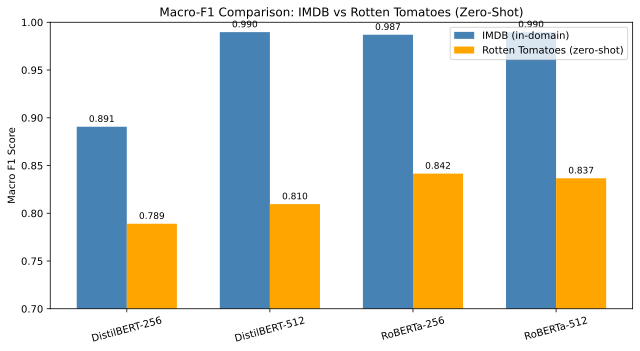

In [441]:
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
bars1 = ax.bar(
    x - width / 2, f1_imdb, width, label="IMDB (in-domain)", color="steelblue"
)
bars2 = ax.bar(
    x + width / 2,
    f1_rt,
    width,
    label="Rotten Tomatoes (zero-shot)",
    color="orange",
)

ax.set_ylabel("Macro F1 Score")
ax.set_title("Macro-F1 Comparison: IMDB vs Rotten Tomatoes (Zero-Shot)")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylim(0.7, 1.0)
ax.legend()

# Annoter les barres avec les valeurs
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f"{height:.3f}",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
        )

plt.tight_layout()
plt.show()

Le graphique ci-dessus met en exergue les éléments ci-après.

Tout d’abord, sur le jeu **IMDB** (*in-domain*), les quatre modèles atteignent des performances très élevées :

- `RoBERTa-256` et `RoBERTa-512` culminent à **0,987–0,990** de F1-score,
- `DistilBERT-512` atteint également **0,990**,
- tandis que `DistilBERT-256` reste légèrement en retrait à **0,891**, ce qui confirme l’influence de la longueur maximale de séquence.

Ensuite, en mode **zero-shot** sur *Rotten Tomatoes*, les **F1-scores** diminuent pour l’ensemble des modèles, traduisant la difficulté de transfert vers un corpus différent :

- `DistilBERT-256` chute à **0,789** ;
- `DistilBERT-512` se maintient à **0,810** ;
- `RoBERTa-256` reste légèrement au-dessus, à **0,842** ;
- `RoBERTa-512` obtient **0,837**

Enfin, la comparaison met en évidence que :

- `RoBERTa` conserve un léger avantage de généralisation sur `DistilBERT`,
- l’allongement à **512 tokens** améliore la robustesse pour `DistilBERT`, mais pas nécessairement pour `RoBERTa`,
- aucun modèle n’atteint les F1-scores observés sur IMDB.

De plus un comportement intéressant est à noter sur la performance respective du modèle RoBERTa configuré avec 256 ou 512 *tokens*.

Il est intéressant de constater que **RoBERTa-256 (0,842)** fait légèrement mieux que **RoBERTa-512 (0,837)** sur Rotten Tomatoes.
Cela suggère que, dans ce contexte, une fenêtre trop longue peut introduire du **bruit** ou une information moins pertinente, ce qui pénalise légèrement la capacité de généralisation.

En résumé, ce graphique illustre le compromis entre excellente performance en domaine d'entraînement et baisse inévitable des F1-scores en généralisation zero-shot.

# Conclusion

Ce travail a permis de comparer deux modèles de la famille des *Transformers* — **DistilBERT** et **RoBERTa** — sur une tâche de classification de sentiments à partir du jeu de données **IMDB**.
Les expériences ont montré que :

- Sur le jeu *in-domain* (IMDB), les deux architectures atteignent des **performances très élevées** (F1-score > 0,98 pour RoBERTa et DistilBERT-512), confirmant l’efficacité du fine-tuning des modèles pré-entraînés.
- **DistilBERT-256** reste en retrait, ce qui souligne l’importance du paramètre `max_length` et la perte d’information liée à un contexte trop court.
- L’augmentation de la fenêtre de contexte à **512 tokens** améliore sensiblement les résultats pour DistilBERT, au point de rejoindre le niveau de RoBERTa-256.
- **RoBERTa-512** conserve un léger avantage global, combinant architecture robuste et couverture contextuelle étendue.

En mode **zero-shot** sur *Rotten Tomatoes*, une baisse générale des F1-scores est observée, traduisant la difficulté de transfert entre corpus :

- DistilBERT-256 chute nettement,
- DistilBERT-512 et RoBERTa maintiennent des scores supérieurs à 0,80,
- RoBERTa-256 surpasse légèrement RoBERTa-512, ce qui suggère que l’élargissement du contexte peut parfois introduire du bruit et nuire à la généralisation.

Ces résultats mettent en évidence un compromis entre **puissance de l’architecture** et **taille de la fenêtre de contexte** :

- une architecture plus simple peut être renforcée par une couverture textuelle plus large,
- tandis qu’une architecture plus robuste généralise mieux, même avec un contexte plus réduit.

En perspective, plusieurs prolongements peuvent être envisagés :

- tester d’autres jeux de données pour évaluer la robustesse au transfert,
- explorer des stratégies de régularisation ou de recherche de seuil optimisé,
- comparer avec des modèles plus récents (ex. DeBERTa, GPT-like adaptés à la classification).